In [287]:
import os
import numpy as np
import h5py
import matplotlib.pyplot as plt

from scipy.signal import butter, filtfilt
from scipy import sparse
from scipy.sparse.linalg import spsolve

try:
    from sklearn.linear_model import Lasso
except Exception:
    Lasso = None
from pybaselines import Baseline
plt.rcParams["figure.figsize"] = (14, 4)
plt.rcParams["axes.grid"] = True


In [288]:
from scipy.signal import butter, filtfilt, decimate
def list_doric_channels(path):
    with h5py.File(path, "r") as f:
        base = f["DataAcquisition"]["FPConsole"]["Signals"]["Series0001"]
        chans = []
        if "LockInAOUT02" in base:
            for k in base["LockInAOUT02"].keys():
                if k.startswith("AIN"):
                    chans.append(k)
        chans = sorted(chans)

        digital = []
        if "DigitalIO" in base:
            for k in base["DigitalIO"].keys():
                if k.startswith("DIO"):
                    digital.append(k)
        return chans, digital

def load_doric(path, channel="AIN01", signal_folder="LockInAOUT02", ref_folder="LockInAOUT01",
              trigger_name=None):
    """
    Returns dict with:
      time, sig465, ref405, fs, (optional) trig_time, trig
    """
    with h5py.File(path, "r") as f:
        base = f["DataAcquisition"]["FPConsole"]["Signals"]["Series0001"]

        sig = np.asarray(base[signal_folder][channel][()], float)
        ref = np.asarray(base[ref_folder][channel][()], float)

        # time: prefer the matching folder time if size matches
        t_sig = np.asarray(base[signal_folder]["Time"][()], float) if "Time" in base[signal_folder] else np.array([])
        t_ref = np.asarray(base[ref_folder]["Time"][()], float) if "Time" in base[ref_folder] else np.array([])

        if t_sig.size == sig.size:
            t = t_sig
        elif t_ref.size == sig.size:
            t = t_ref
        else:
            # fallback
            dt = np.nanmedian(np.diff(t_sig)) if t_sig.size > 2 else 1/1000
            t = np.arange(sig.size) * dt

        # if ref length differs, interpolate onto t if possible
        if ref.size != sig.size:
            if t_ref.size == ref.size:
                ref = np.interp(t, t_ref, ref)
            else:
                ref = np.resize(ref, sig.size)

        # sampling rate
        fs = 1.0 / float(np.nanmedian(np.diff(t))) if t.size > 2 else np.nan

        # optional digital trigger overlay
        trig_time = None
        trig = None
        if trigger_name:
            if "DigitalIO" in base and trigger_name in base["DigitalIO"]:
                dio = base["DigitalIO"]
                trig = np.asarray(dio[trigger_name][()], float)
                trig_time = np.asarray(dio["Time"][()], float) if "Time" in dio else None

                # if lengths mismatch, interpolate signals to trigger time (like your Doric logic)
                if trig_time is not None and trig_time.size and trig_time.size != t.size:
                    sig = np.interp(trig_time, t, sig)
                    ref = np.interp(trig_time, t, ref)
                    t = trig_time
                    fs = 1.0 / float(np.nanmedian(np.diff(t))) if t.size > 2 else fs

    out = {"time": t, "sig465": sig, "ref405": ref, "fs": fs}
    if trig is not None and trig_time is not None:
        out["trig_time"] = trig_time
        out["trig"] = trig
    return out
import numpy as np
import numpy as np

def _nan_interp_1d(y: np.ndarray) -> np.ndarray:
    """
    Linearly interpolate NaNs in a 1D array.
    Edge NaNs are filled with nearest valid value.
    """
    y = np.asarray(y, float).copy()
    n = y.size
    if n == 0:
        return y

    isnan = ~np.isfinite(y)
    if not np.any(isnan):
        return y

    x = np.arange(n)
    good = np.isfinite(y)
    if np.sum(good) == 0:
        # nothing to interpolate from
        return y

    y[isnan] = np.interp(x[isnan], x[good], y[good])
    return y


def adaptive_mad_artifact_mask(
    y: np.ndarray,
    fs: float,
    *,
    k: float = 6.0,
    window_s: float = 1.0,
    pad_s: float = 0.2,
    use_derivative: bool = True,
    min_mad: float = 1e-12,
) -> np.ndarray:
    """
    Build an artifact mask using Adaptive MAD (windowed).

    Detection is performed on dx=diff(y) if use_derivative=True, else directly on y.
    Within each non-overlapping window, compute median and MAD, then flag samples where:
        |x - median| > k * MAD

    Mask is returned at signal sample resolution (len(y)).
    """
    y = np.asarray(y, float)
    n = y.size
    if n == 0:
        return np.zeros((0,), dtype=bool)

    if not np.isfinite(fs) or fs <= 0:
        raise ValueError(f"adaptive_mad_artifact_mask: invalid fs={fs}")

    x = np.diff(y) if use_derivative else y.copy()
    # x length is n-1 if derivative else n
    nx = x.size
    if nx == 0:
        return np.zeros((n,), dtype=bool)

    win = int(round(window_s * fs))
    win = max(5, win)  # avoid tiny windows

    flagged_x = np.zeros((nx,), dtype=bool)

    # Process non-overlapping windows (fast, “adaptive” across time)
    for start in range(0, nx, win):
        stop = min(start + win, nx)
        seg = x[start:stop]

        # Ignore non-finite values in stats
        seg_f = seg[np.isfinite(seg)]
        if seg_f.size < 5:
            continue

        med = np.median(seg_f)
        mad = np.median(np.abs(seg_f - med))
        mad = max(float(mad), float(min_mad))

        flagged_x[start:stop] = np.abs(seg - med) > (k * mad)

    # Map flagged_x back to signal sample mask (len(y))
    mask = np.zeros((n,), dtype=bool)
    if use_derivative:
        # A large dx affects both samples around the step
        hit = np.where(flagged_x)[0]
        mask[hit] = True
        mask[hit + 1] = True
    else:
        mask[:nx] = flagged_x  # nx == n in this mode

    # Pad mask by pad_s seconds
    pad_n = int(round(pad_s * fs))
    if pad_n > 0 and np.any(mask):
        kernel = np.ones((2 * pad_n + 1,), dtype=int)
        mask = (np.convolve(mask.astype(int), kernel, mode="same") > 0)

    return mask


import numpy as np
import matplotlib.pyplot as plt
from typing import Optional

def remove_artifacts_adaptive_mad(
    time: np.ndarray,
    sig465: np.ndarray,
    ref405: np.ndarray,
    fs: float = None,
    *,
    k: float = 7.0,
    window_s: float = 1.0,
    pad_s: float = 0.2,
    union_channels: bool = True,
    use_derivative: bool = True,
    # --- NEW plotting options ---
    plot: bool = True,
    plot_decim: int = 1,
    plot_show_mask: bool = True,
    plot_alpha_mask: float = 0.20,
    plot_xlim= None,
    plot_title=None,
) -> dict:
    """
    Detect + remove artifacts using adaptive MAD (windowed) with padding.

    By default, artifacts are detected on BOTH channels and unioned (recommended),
    then removed from BOTH channels consistently.

    Plotting:
      - plot=True: show before/after for both channels + (optional) artifact mask shading.

    Returns a dict:
      {
        "time": time,
        "sig465_clean": ...,
        "ref405_clean": ...,
        "artifact_mask": ...,
        "artifact_regions_s": [(t0,t1), ...],
        "fs": fs
      }
    """
    t = np.asarray(time, float)
    s = np.asarray(sig465, float)
    r = np.asarray(ref405, float)

    n = min(t.size, s.size, r.size)
    t, s, r = t[:n], s[:n], r[:n]

    if fs is None:
        fs = 1.0 / float(np.nanmedian(np.diff(t))) if t.size > 2 else np.nan
    if not np.isfinite(fs) or fs <= 0:
        raise ValueError(f"remove_artifacts_adaptive_mad: invalid fs={fs}")

    m_s = adaptive_mad_artifact_mask(s, fs, k=k, window_s=window_s, pad_s=pad_s, use_derivative=use_derivative)
    m_r = adaptive_mad_artifact_mask(r, fs, k=k, window_s=window_s, pad_s=pad_s, use_derivative=use_derivative)

    mask = (m_s | m_r) if union_channels else m_s

    # Keep a copy for plotting / debugging
    s_raw = s.copy()
    r_raw = r.copy()

    # Remove artifacts and interpolate
    s_clean = s_raw.copy()
    r_clean = r_raw.copy()
    s_clean[mask] = np.nan
    r_clean[mask] = np.nan

    s_clean = _nan_interp_1d(s_clean)
    r_clean = _nan_interp_1d(r_clean)

    # Build contiguous regions in seconds
    regions = []
    if np.any(mask):
        idx = np.where(mask)[0]
        breaks = np.where(np.diff(idx) > 1)[0]
        starts = np.r_[idx[0], idx[breaks + 1]]
        ends   = np.r_[idx[breaks], idx[-1]]
        for a, b in zip(starts, ends):
            regions.append((float(t[a]), float(t[b])))

    # --- NEW: plotting ---
    if plot:
        d = max(int(plot_decim), 1)
        tt = t[::d]
        sr = s_raw[::d]
        sc = s_clean[::d]
        rr = r_raw[::d]
        rc = r_clean[::d]
        mm = mask[::d]

        fig, axs = plt.subplots(2, 1, figsize=(14, 6.5), sharex=True, constrained_layout=True)

        # 465
        ax = axs[0]
        ax.plot(tt, sr, color="0.55", lw=1.0, label="465 raw")
        ax.plot(tt, sc, color="red", lw=1.2, label="465 cleaned")
        ax.set_ylabel("Signal 465")
        ax.grid(True, alpha=0.15)
        ax.legend(frameon=False, loc="upper right")

        # apply shading AFTER limits exist (force draw-limits)
        ax.relim(); ax.autoscale_view()


        # 405
        ax = axs[1]
        ax.plot(tt, rr, color="0.55", lw=1.0, label="405 raw")
        ax.plot(tt, rc, color="red", lw=1.2, label="405 cleaned")
        ax.set_ylabel("Reference 405")
        ax.set_xlabel("Time (s)")
        ax.grid(True, alpha=0.15)
        ax.legend(frameon=False, loc="upper right")

        ax.relim(); ax.autoscale_view()


        if plot_xlim is not None:
            axs[1].set_xlim(plot_xlim)

        if plot_title is None:
            plot_title = f"Artifact removal (k={k}, window={window_s}s, pad={pad_s}s, union={union_channels}, deriv={use_derivative})"
        fig.suptitle(plot_title, y=1.02, fontsize=12)

        plt.show()

    return {
        "time": t,
        "sig465_clean": s_clean,
        "ref405_clean": r_clean,
        "artifact_mask": mask,
        "artifact_regions_s": regions,
        "fs": fs,
    }


def ols_fit(x, y):
    x = np.asarray(x, float)
    y = np.asarray(y, float)
    m = np.isfinite(x) & np.isfinite(y)
    if np.sum(m) < 10:
        return 1.0, 0.0
    X = np.vstack([x[m], np.ones(np.sum(m))]).T
    coef, *_ = np.linalg.lstsq(X, y[m], rcond=None)
    return float(coef[0]), float(coef[1])
def preprocess_signal(sig, fs_raw, target_fs=100, lpf_cutoff=3):
    """
    1\) Low-pass filter (Butterworth, lpf_cutoff Hz)
    2\) Decimate to target sampling rate (target_fs Hz)
    """
    nyquist = 0.5 * fs_raw
    normal_cutoff = lpf_cutoff / nyquist
    b, a = butter(N=2, Wn=normal_cutoff, btype="low", analog=False)
    sig_filtered = filtfilt(b, a, sig)

    q = int(fs_raw / target_fs)
    if q > 1:
        sig_downsampled = decimate(sig_filtered, q)
        real_fs = fs_raw / q
    else:
        sig_downsampled = sig_filtered
        real_fs = fs_raw

    return sig_downsampled, real_fs


def compute_arpls_baselines(
    baseline_fitter,
    sig_f,
    ref_f,
    lam=1e9,
    diff_order=2,
    max_iter=50,
    tol=1e-3,
):
    """
    Compute arPLS baselines for signal and reference.

    Parameters:
        baseline_fitter: pybaselines.Baseline instance, already set up with x_data.
        sig_f: 1D array-like, preprocessed signal channel.
        ref_f: 1D array-like, preprocessed reference channel.
        lam: smoothing parameter.
        diff_order: difference order for the penalty.
        max_iter: maximum iterations for arPLS.
        tol: convergence tolerance.

    Returns:
        b_sig_arpls, b_ref_arpls
    """
    b_sig_arpls, _ = baseline_fitter.arpls(
        sig_f, lam=lam, diff_order=diff_order,
        max_iter=max_iter, tol=tol
    )
    b_ref_arpls, _ = baseline_fitter.arpls(
        ref_f, lam=lam, diff_order=diff_order,
        max_iter=max_iter, tol=tol
    )
    return b_sig_arpls, b_ref_arpls




import numpy as np
import statsmodels.api as sm

def compute_motion_corrected_dff_robust(sig_f, ref_f, b_sig, b_ref):
    """
    Computes motion-corrected dF/F using dF/F-first strategy and Robust Regression.
    """
    # --- 1. Calculate raw dF/F for each channel ---
    # Safe division
    den_sig = np.asarray(b_sig, float).copy()
    den_sig[np.abs(den_sig) < 1e-12] = np.nan
    dff_sig_raw = (sig_f - b_sig) / den_sig

    den_ref = np.asarray(b_ref, float).copy()
    den_ref[np.abs(den_ref) < 1e-12] = np.nan
    dff_ref_raw = (ref_f - b_ref) / den_ref

    # Handle NaNs created by division (optional but recommended)
    valid_mask = ~np.isnan(dff_sig_raw) & ~np.isnan(dff_ref_raw)

    # --- 2. Fit Reference to Signal using Robust Linear Model (IRLS) ---
    # Prepare data for statsmodels (needs constant for intercept)
    X = dff_ref_raw[valid_mask]
    Y = dff_sig_raw[valid_mask]
    X_const = sm.add_constant(X)

    # RLM with HuberT weighting reduces impact of calcium spikes
    model = sm.RLM(Y, X_const, M=sm.robust.norms.HuberT())
    results = model.fit()

    b_fit, a_fit = results.params  # Intercept (b), Slope (a)

    # --- 3. Subtract Fitted Reference ---
    # fitted_ref = slope * ref + intercept
    fitted_ref = a_fit * dff_ref_raw + b_fit
    dff_mc = dff_sig_raw - fitted_ref

    return {
        "sig_det": dff_sig_raw,
        "ref_det": dff_ref_raw,
        "a": a_fit,
        "b": b_fit,
        "dff": dff_mc
    }

def list_doric_files(folder_path):
    """
    Return a list of full paths to all .doric files in the given folder.
    """
    doric_files = []
    for fname in os.listdir(folder_path):
        if fname.lower().endswith(".doric"):
            doric_files.append(os.path.join(folder_path, fname))
    return doric_files
def list_labels_files(folder_path):
    """
    Return a list of full paths to all .doric files in the given folder.
    """
    doric_files = []
    for fname in os.listdir(folder_path):
        if fname.lower().endswith(".csv"):
            doric_files.append(os.path.join(folder_path, fname))
    return doric_files
import numpy as np
import matplotlib.pyplot as plt

def qc_sig_ref_correlation(sig, ref, title="", max_points=8000, ax=None):
    """
    Scatter sig vs ref with OLS fit + Pearson R, R^2.
    Downsamples points for plotting but computes stats on full data.
    Returns dict with r, r2, slope, intercept, n.
    """
    sig = np.asarray(sig, float)
    ref = np.asarray(ref, float)

    m = np.isfinite(sig) & np.isfinite(ref)
    sig = sig[m]
    ref = ref[m]
    n = int(sig.size)

    out = {"r": np.nan, "r2": np.nan, "slope": np.nan, "intercept": np.nan, "n": n}

    if n < 10:
        return out

    # Pearson R
    s0 = sig - np.mean(sig)
    r0 = ref - np.mean(ref)
    denom = np.sqrt(np.sum(s0**2) * np.sum(r0**2))
    if denom > 0:
        r = float(np.sum(s0 * r0) / denom)
    else:
        r = np.nan
    out["r"] = r
    out["r2"] = float(r**2) if np.isfinite(r) else np.nan

    # OLS fit sig = a*ref + b
    X = np.vstack([ref, np.ones_like(ref)]).T
    coef, *_ = np.linalg.lstsq(X, sig, rcond=None)
    a, b = float(coef[0]), float(coef[1])
    out["slope"] = a
    out["intercept"] = b

    # Plot
    if ax is None:
        fig, ax = plt.subplots(figsize=(4.2, 3.6))

    # downsample points for display
    if n > max_points:
        idx = np.random.default_rng(0).choice(n, size=max_points, replace=False)
        xs = ref[idx]
        ys = sig[idx]
    else:
        xs, ys = ref, sig

    ax.scatter(xs, ys, s=6, alpha=0.25, edgecolors="none")

    # fit line over displayed x-range
    xlo, xhi = np.nanpercentile(ref, [1, 99])
    xx = np.linspace(xlo, xhi, 200)
    yy = a * xx + b
    ax.plot(xx, yy, lw=1.8)

    ax.set_title(title, fontsize=10)
    ax.set_xlabel("Reference 405 (a.u.)")
    ax.set_ylabel("Signal 465 (a.u.)")

    # cosmetics
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.grid(True, alpha=0.15)

    ax.text(
        0.02, 0.98,
        f"R = {out['r']:.3f}\nR² = {out['r2']:.3f}\na = {a:.3g}",
        transform=ax.transAxes, va="top", ha="left", fontsize=9
    )

    return out

In [289]:
folder = r'C:\Analysis\fiber_photometry_app\test_data\EPM'
doric_paths = list_doric_files(folder)
labels_paths = list_labels_files(folder)
print(doric_paths)
print(labels_paths)

['C:\\Analysis\\fiber_photometry_app\\test_data\\EPM\\030545_EPM.doric', 'C:\\Analysis\\fiber_photometry_app\\test_data\\EPM\\030547_EPM.doric']
['C:\\Analysis\\fiber_photometry_app\\test_data\\EPM\\030545_EPM.csv', 'C:\\Analysis\\fiber_photometry_app\\test_data\\EPM\\030547_EPM.csv']


In [290]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def read_epm_labels(path):
    """
    Robust EPM label reader:
      - handles tab-separated
      - handles decimal commas in 'time'
    Expected columns: time, trigger, ttl, open, closed
    """
    df = pd.read_csv(path, sep=None, engine="python", decimal=",")
    df.columns = [c.strip().lower() for c in df.columns]

    # required columns (case-insensitive)
    required = {"time", "ttl", "open", "closed"}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"{os.path.basename(path)} missing columns: {missing}. Found: {list(df.columns)}")

    # force numeric
    for c in ["time", "ttl", "open", "closed"]:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    # optional columns
    if "trigger" in df.columns:
        df["trigger"] = pd.to_numeric(df["trigger"], errors="coerce")
    else:
        df["trigger"] = np.nan

    df = df.dropna(subset=["time"]).reset_index(drop=True)
    return df


def rising_edges(t, x, threshold=0.5, min_isi_s=0.4):
    """
    Return rising-edge times (0->1 transitions) in x(t).
    min_isi_s merges edges closer than this.
    """
    t = np.asarray(t, float)
    x = np.asarray(x, float)
    m = np.isfinite(t) & np.isfinite(x)
    t = t[m]
    x = x[m]
    if t.size < 3:
        return np.array([], float)

    b = x > threshold
    db = np.diff(b.astype(int))
    idx = np.where(db == 1)[0] + 1
    edges = t[idx]

    # merge close edges
    if edges.size > 1 and min_isi_s is not None and min_isi_s > 0:
        keep = [0]
        for i in range(1, edges.size):
            if (edges[i] - edges[keep[-1]]) >= float(min_isi_s):
                keep.append(i)
        edges = edges[keep]

    return edges


def fit_affine_time_map_from_edges(fiber_edges, video_edges, max_shift=6, min_pairs=6):
    """
    Fit t_video ≈ a*t_fiber + b using rising edges.
    Robust to extra pulses at start by scanning small index shifts.
    Returns dict with a,b, rmse, n_pairs, shift_fiber, shift_video.
    """
    fiber_edges = np.asarray(fiber_edges, float)
    video_edges = np.asarray(video_edges, float)

    best = None

    if fiber_edges.size < min_pairs or video_edges.size < min_pairs:
        return {
            "ok": False, "a": np.nan, "b": np.nan, "rmse": np.nan,
            "n_pairs": 0, "shift_fiber": 0, "shift_video": 0
        }

    # try aligning by trimming a few edges from either series
    for sf in range(0, max_shift + 1):
        for sv in range(0, max_shift + 1):
            fe = fiber_edges[sf:]
            ve = video_edges[sv:]
            L = min(fe.size, ve.size)
            if L < min_pairs:
                continue

            fe = fe[:L]
            ve = ve[:L]

            # linear fit ve = a*fe + b
            a, b = np.polyfit(fe, ve, 1)
            pred = a * fe + b
            rmse = float(np.sqrt(np.nanmean((pred - ve) ** 2)))

            cand = {"a": float(a), "b": float(b), "rmse": rmse, "n_pairs": int(L),
                    "shift_fiber": int(sf), "shift_video": int(sv)}

            if best is None or cand["rmse"] < best["rmse"]:
                best = cand

    if best is None:
        return {
            "ok": False, "a": np.nan, "b": np.nan, "rmse": np.nan,
            "n_pairs": 0, "shift_fiber": 0, "shift_video": 0
        }

    best["ok"] = True
    return best


def _binary_runs(time, binary_vec, thr=0.5):
    """
    Return list of (t_start, t_end) for contiguous True runs.
    """
    time = np.asarray(time, float)
    b = np.asarray(binary_vec, float) > thr
    if time.size == 0 or b.size == 0 or time.size != b.size:
        return []

    db = np.diff(b.astype(int))
    starts = np.where(db == 1)[0] + 1
    ends   = np.where(db == -1)[0] + 1

    if b[0]:
        starts = np.r_[0, starts]
    if b[-1]:
        ends = np.r_[ends, b.size]

    runs = []
    for s, e in zip(starts, ends):
        t0 = float(time[s])
        t1 = float(time[e-1]) if e-1 < time.size else float(time[-1])
        runs.append((t0, t1))
    return runs


def plot_epm_aligned(beh_time, z_aligned, open_vec, closed_vec, *, title="", xlim=None):
    """
    Plot aligned Z-score with shaded open/closed epochs.
    """
    beh_time = np.asarray(beh_time, float)
    z_aligned = np.asarray(z_aligned, float)

    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(beh_time, z_aligned, lw=1.2, label="Fiber z-score (aligned)")

    # shade open/closed
    open_runs = _binary_runs(beh_time, open_vec, thr=0.5)
    closed_runs = _binary_runs(beh_time, closed_vec, thr=0.5)

    for (t0, t1) in open_runs:
        ax.axvspan(t0, t1, alpha=0.18, color="tab:green", label="_open")
    for (t0, t1) in closed_runs:
        ax.axvspan(t0, t1, alpha=0.18, color="tab:red", label="_closed")

    # legend proxies (avoid duplicates)
    handles = [
        plt.Line2D([0],[0], color="k", lw=1.2, label="Z-score"),
        plt.Line2D([0],[0], color="tab:green", lw=8, alpha=0.18, label="Open arm"),
        plt.Line2D([0],[0], color="tab:red", lw=8, alpha=0.18, label="Closed arm"),
    ]
    ax.legend(handles=handles, frameon=False, loc="upper right")

    ax.set_title(title, fontsize=12)
    ax.set_xlabel("Time (video, s)")
    ax.set_ylabel("Z")
    ax.grid(True, alpha=0.15)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    if xlim is not None:
        ax.set_xlim(xlim)

    plt.tight_layout()
    plt.show()


Processing: 030545_EPM.doric | animal=030545 | labels=030545_EPM.csv


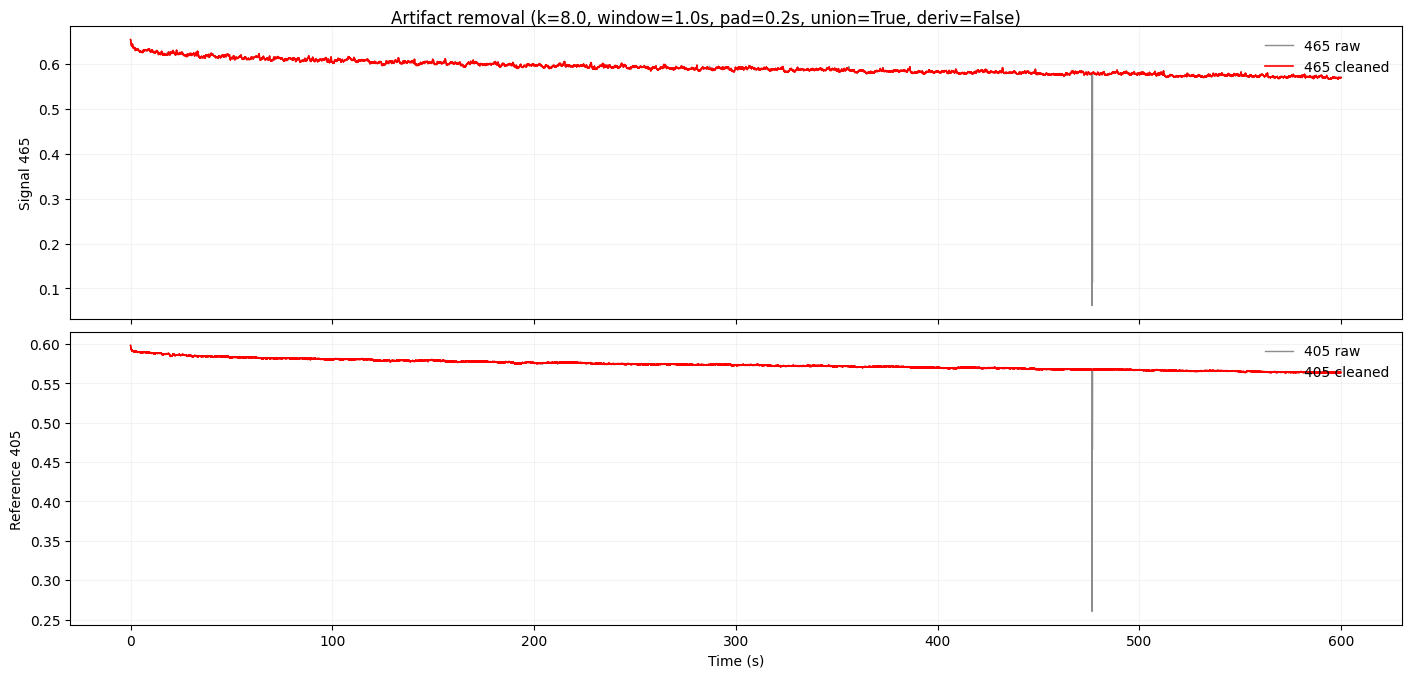

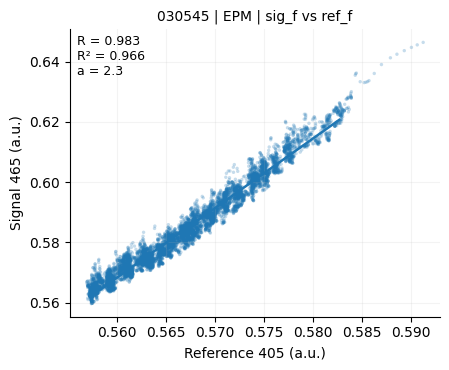

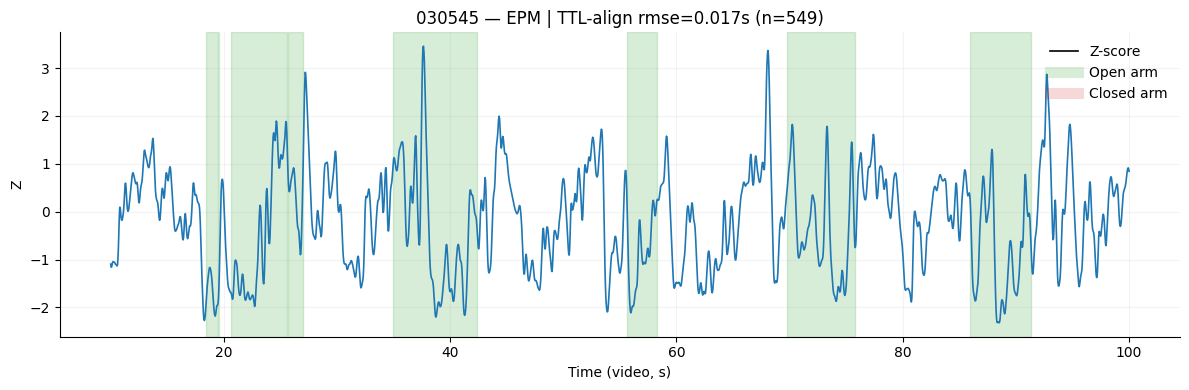

Processing: 030547_EPM.doric | animal=030547 | labels=030547_EPM.csv


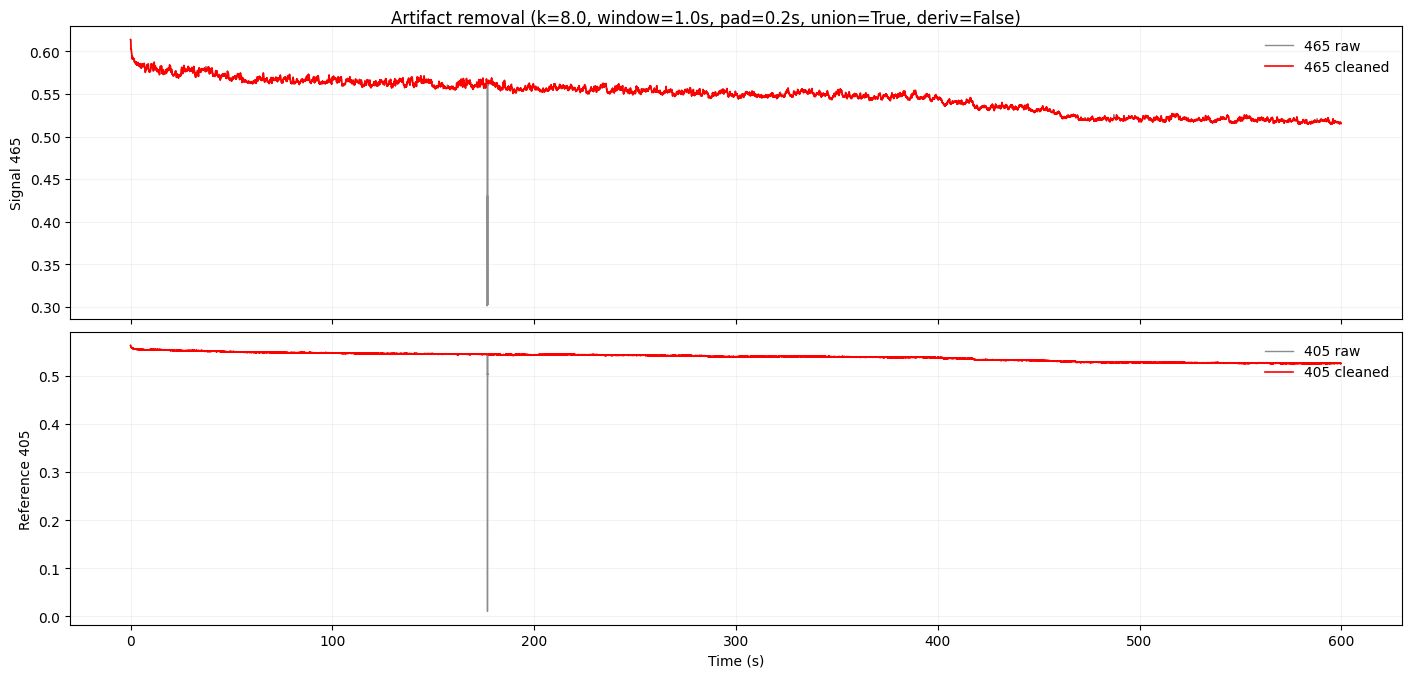

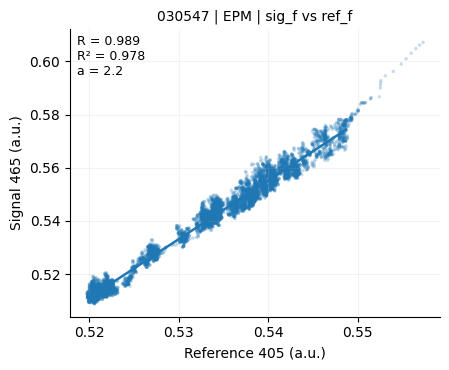

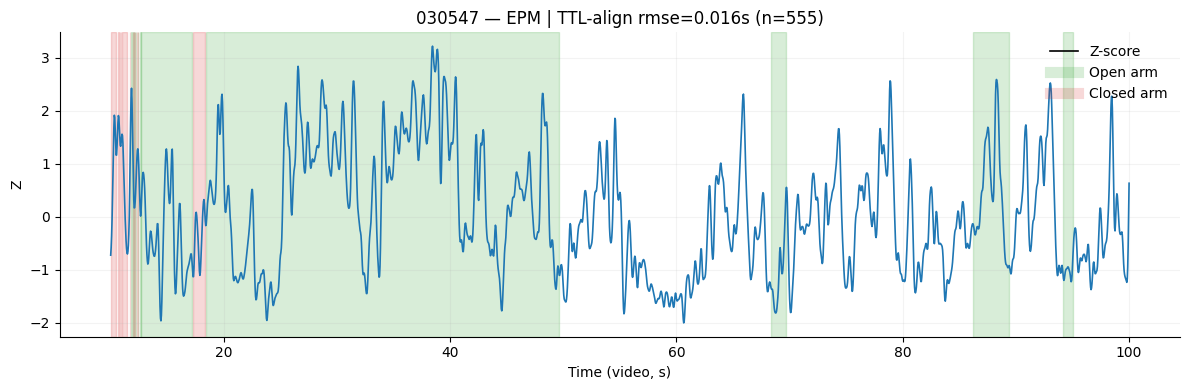

Done. Stored EPM results for 2 recordings.


In [291]:
# -----------------------------
# Parameters
# -----------------------------
target_fs = 30
lpf_cutoff = 3
lam = 1e12
diff_order = 2
max_iter = 50
tol = 1e-3

# Artifact removal
art_k = 8.0
art_window_s = 1.0
art_pad_s = 0.2
art_union_channels = True
art_use_derivative = False

# Plot window (video-time after alignment)
plot_window = [10, 100]   # set None for full
# plot_window = None

def apply_plot_window(t, *series, plot_window=None):
    t = np.asarray(t, float)
    if plot_window is None:
        mask = np.ones_like(t, dtype=bool)
        return (t, *series, mask)

    lo, hi = float(plot_window[0]), float(plot_window[1])
    if lo > hi:
        lo, hi = hi, lo
    mask = (t >= lo) & (t <= hi)
    t2 = t[mask]
    series2 = [np.asarray(s)[mask] if s is not None else None for s in series]
    return (t2, *series2, mask)

# -----------------------------
# Map label files by animal
# Adjust parsing here if your EMP csv filenames differ
# -----------------------------
label_by_animal = {}
for lp in labels_paths:
    base = os.path.splitext(os.path.basename(lp))[0]
    # Common cases: "030545" or "030545_EPM" etc.
    animal_id = base.split("_")[0].split("-")[0]
    label_by_animal[animal_id] = lp

# -----------------------------
# Outputs
# -----------------------------
epm_result_list = []
epm_align_qc = []  # TTL alignment quality per recording
qc_list = []       # sig/ref QC if you keep it

for path in doric_paths:
    filename = os.path.basename(path)
    file_name = os.path.splitext(filename)[0]
    animal_id = file_name.split("_")[0].split("-")[0]
    condition = "EPM"  # single condition

    if animal_id not in label_by_animal:
        print(f"Skipping {animal_id}: no label csv found.")
        continue

    label_path = label_by_animal[animal_id]
    print(f"Processing: {filename} | animal={animal_id} | labels={os.path.basename(label_path)}")

    # -------------------- Load photometry (with DIO02) --------------------
    rec = load_doric(path, trigger_name="DIO02")
    t_raw = rec["time"]
    sig_raw = rec["sig465"]
    ref_raw = rec["ref405"]
    fs_raw = rec["fs"]

    dio_raw = rec.get("trig", None)
    dio_time = rec.get("trig_time", None)

    # -------------------- Artifact removal FIRST --------------------
    art = remove_artifacts_adaptive_mad(
        t_raw, sig_raw, ref_raw, fs_raw,
        k=art_k, window_s=art_window_s, pad_s=art_pad_s,
        union_channels=art_union_channels,
        use_derivative=art_use_derivative
    )

    sig = art["sig465_clean"]
    ref = art["ref405_clean"]
    t_raw = art["time"]
    fs = art["fs"]

    # -------------------- Preprocess & downsample --------------------
    sig_f, fs_sig = preprocess_signal(sig, fs, target_fs=target_fs, lpf_cutoff=lpf_cutoff)
    ref_f, fs_ref = preprocess_signal(ref, fs, target_fs=target_fs, lpf_cutoff=lpf_cutoff)

    # QC scatter (optional)
    qc_title = f"{animal_id} | {condition} | sig_f vs ref_f"
    fig_qc, ax_qc = plt.subplots(figsize=(4.6, 3.8))
    qc = qc_sig_ref_correlation(sig_f, ref_f, title=qc_title, ax=ax_qc)
    plt.tight_layout()
    plt.show()

    qc.update({
        "animal": animal_id,
        "condition": condition,
        "file": filename,
        "artifact_fraction": float(np.mean(art["artifact_mask"])) if art["artifact_mask"].size else 0.0,
        "fs_used": float(fs_sig),
        "sig_std": float(np.nanstd(sig_f)),
        "ref_std": float(np.nanstd(ref_f)),
    })
    qc_list.append(qc)

    # photometry time after decimation
    dt_ds = 1.0 / fs_sig
    t_ds = np.arange(sig_f.size) * dt_ds

    # baseline + dff
    baseline_fitter = Baseline(x_data=t_ds)
    b_sig, b_ref = compute_arpls_baselines(
        baseline_fitter, sig_f, ref_f,
        lam=lam, diff_order=diff_order, max_iter=max_iter, tol=tol
    )
    dff_results = compute_motion_corrected_dff_robust(sig_f, ref_f, b_sig, b_ref)
    dff_mc = dff_results["dff"]
    dff_z = (dff_mc - np.nanmean(dff_mc)) / np.nanstd(dff_mc)

    # resample DIO to t_ds
    if dio_raw is not None and dio_time is not None and np.size(dio_raw) and np.size(dio_time):
        dio_ds = np.interp(t_ds, dio_time, np.asarray(dio_raw, float))
    else:
        dio_ds = np.zeros_like(t_ds)

    # -------------------- Load EPM labels --------------------
    beh = read_epm_labels(label_path)
    beh_time = beh["time"].to_numpy(dtype=float)
    ttl_video = beh["ttl"].to_numpy(dtype=float)
    open_vec = beh["open"].to_numpy(dtype=float)
    closed_vec = beh["closed"].to_numpy(dtype=float)

    # -------------------- TTL alignment (video ttl vs photometry dio2) --------------------
    video_edges = rising_edges(beh_time, ttl_video, threshold=0.5, min_isi_s=0.4)
    fiber_edges = rising_edges(t_ds, dio_ds, threshold=0.5, min_isi_s=0.4)

    align = fit_affine_time_map_from_edges(
        fiber_edges, video_edges,
        max_shift=8, min_pairs=6
    )

    if not align["ok"]:
        print(f"  Alignment failed for {animal_id}. Edges: fiber={fiber_edges.size}, video={video_edges.size}")
        continue

    # map fiber time -> video time
    a, b = align["a"], align["b"]
    t_ds_video = a * t_ds + b

    # interpolate zscore onto video time vector (behavior sampling)
    # (fiber defined on t_ds_video, want z at beh_time)
    m = np.isfinite(t_ds_video) & np.isfinite(dff_z)
    t_map = t_ds_video[m]
    z_map = dff_z[m]
    # ensure monotonic for interp
    order = np.argsort(t_map)
    t_map = t_map[order]
    z_map = z_map[order]

    z_aligned = np.interp(beh_time, t_map, z_map, left=np.nan, right=np.nan)
    beh = beh.copy()
    beh["fiber_zscore_aligned"] = z_aligned

    # alignment QC: edge RMSE on matched pulses
    epm_align_qc.append({
        "animal": animal_id,
        "file": filename,
        "label_file": os.path.basename(label_path),
        "a": float(a),
        "b": float(b),
        "rmse_s": float(align["rmse"]),
        "n_pairs": int(align["n_pairs"]),
        "shift_fiber": int(align["shift_fiber"]),
        "shift_video": int(align["shift_video"]),
        "n_edges_fiber": int(fiber_edges.size),
        "n_edges_video": int(video_edges.size),
    })

    # -------------------- Store results for later analysis --------------------
    out = {
        "animal": animal_id,
        "condition": condition,
        # photometry
        "t_fiber": t_ds,
        "t_fiber_in_video": t_ds_video,
        "dff": dff_mc,
        "zscore": dff_z,
        "dio2": dio_ds,
        "artifact_regions_s": art["artifact_regions_s"],
        "artifact_fraction": float(np.mean(art["artifact_mask"])) if art["artifact_mask"].size else 0.0,
        # behavior (video timebase)
        "behavior": beh,   # includes open/closed/ttl/trigger + fiber_zscore_aligned
        # time alignment params
        "ttl_align": {
            "a": float(a),
            "b": float(b),
            "rmse_s": float(align["rmse"]),
            "n_pairs": int(align["n_pairs"]),
            "shift_fiber": int(align["shift_fiber"]),
            "shift_video": int(align["shift_video"]),
            "fiber_edges_s": fiber_edges,
            "video_edges_s": video_edges,
        }
    }
    epm_result_list.append(out)

    # -------------------- Plot (Z-score + open/closed shading) --------------------
    t_plot, z_plot, open_plot, closed_plot, _ = apply_plot_window(
        beh_time, z_aligned, open_vec, closed_vec, plot_window=plot_window
    )

    plot_epm_aligned(
        t_plot, z_plot, open_plot, closed_plot,
        title=f"{animal_id} — EPM | TTL-align rmse={align['rmse']:.3f}s (n={align['n_pairs']})",
        xlim=None
    )

print(f"Done. Stored EPM results for {len(epm_result_list)} recordings.")


In [292]:
from typing import Tuple
from scipy.ndimage import gaussian_filter1d

def _compute_psth_matrix(
    t: np.ndarray,
    y: np.ndarray,
    event_times: np.ndarray,
    window: Tuple[float, float],
    baseline_win: Tuple[float, float],
    resample_hz: float,
    smooth_sigma_s: float = 0.0,
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Returns:
      tvec (relative time), mat (n_events x n_samples) with NaNs if missing
    """
    t = np.asarray(t, float)
    y = np.asarray(y, float)
    ev = np.asarray(event_times, float)
    ev = ev[np.isfinite(ev)]
    if ev.size == 0:
        return np.array([], float), np.zeros((0, 0), float)

    dt = 1.0 / float(resample_hz)
    tvec = np.arange(window[0], window[1] + 0.5 * dt, dt)

    mat = np.full((ev.size, tvec.size), np.nan, float)

    for i, et in enumerate(ev):
        # baseline
        bmask = (t >= et + baseline_win[0]) & (t <= et + baseline_win[1])
        base = y[bmask]
        if base.size < 5 or not np.any(np.isfinite(base)):
            continue
        bmean = np.nanmean(base)
        bstd = np.nanstd(base)
        if not np.isfinite(bstd) or bstd <= 1e-12:
            bstd = 1.0

        # extract window and interpolate onto tvec
        wmask = (t >= et + window[0]) & (t <= et + window[1])
        tw = t[wmask] - et
        yw = y[wmask]
        good = np.isfinite(tw) & np.isfinite(yw)
        if np.sum(good) < 5:
            continue
        # sparse interpolation
        mat[i, :] = np.interp(tvec, tw[good], (yw[good] - bmean) / bstd)

    if smooth_sigma_s and smooth_sigma_s > 0:
        # simple gaussian smoothing along time axis
        sigma = smooth_sigma_s * resample_hz
        mat = gaussian_filter1d(mat, sigma=sigma, axis=1, mode="nearest")

    return tvec, mat




In [293]:
import numpy as np
import matplotlib.pyplot as plt

import numpy as np

def extract_transition_events_epm(
    beh_df,
    thr=0.5,
    drop_first=True,
    min_state_dur_s=None,
    drop_unpaired=False,
):
    """
    Extract transition events from EPM behavior vectors, with optional filtering of
    short state bouts by duration.

    Returns dict:
      {
        "open_entry":   np.ndarray of times (s),
        "open_exit":    np.ndarray of times (s),
        "closed_entry": np.ndarray of times (s),
        "closed_exit":  np.ndarray of times (s),
      }

    Definitions (based on binary state):
      open_entry   = open rises (0->1)   = closed falls (1->0)
      open_exit    = open falls (1->0)   = closed rises (0->1)
      closed_entry = closed rises (0->1) = open falls (1->0)
      closed_exit  = closed falls (1->0) = open rises (0->1)

    Optional bout-duration filtering:
      - If min_state_dur_s is not None, events defining a bout shorter than
        min_state_dur_s seconds are removed.
        * open bouts:  (open_entry -> next open_exit)
        * closed bouts:(open_exit  -> next open_entry)
      - If drop_unpaired is True, events without a subsequent corresponding transition
        (e.g., last open_entry with no later open_exit) are dropped when filtering.

    Notes:
      - Filtering is performed using the 'open' transitions primarily, then mirrored
        to 'closed' to maintain symmetry.
    """
    if "time" not in beh_df.columns or "open" not in beh_df.columns or "closed" not in beh_df.columns:
        raise ValueError("beh_df must contain columns: time, open, closed")

    t = beh_df["time"].to_numpy(dtype=float)
    openv = beh_df["open"].to_numpy(dtype=float)
    closedv = beh_df["closed"].to_numpy(dtype=float)

    good = np.isfinite(t) & np.isfinite(openv) & np.isfinite(closedv)
    t = t[good]
    openv = openv[good]
    closedv = closedv[good]

    # Binarize
    o = openv > thr
    c = closedv > thr

    # Transitions from open
    do = np.diff(o.astype(int))
    open_entry_idx = np.where(do == 1)[0] + 1   # 0->1
    open_exit_idx  = np.where(do == -1)[0] + 1  # 1->0

    open_entry = t[open_entry_idx]
    open_exit  = t[open_exit_idx]

    # Transitions from closed (for symmetry)
    dc = np.diff(c.astype(int))
    closed_entry_idx = np.where(dc == 1)[0] + 1
    closed_exit_idx  = np.where(dc == -1)[0] + 1

    closed_entry = t[closed_entry_idx]
    closed_exit  = t[closed_exit_idx]

    # Optional: drop first event of each type
    if drop_first:
        if open_entry.size:  open_entry  = open_entry[1:]
        if open_exit.size:   open_exit   = open_exit[1:]
        if closed_entry.size:closed_entry= closed_entry[1:]
        if closed_exit.size: closed_exit = closed_exit[1:]

    # Optional: filter out short bouts using open transitions
    if min_state_dur_s is not None:
        min_state_dur_s = float(min_state_dur_s)

        def _forward_duration(a, b):
            """Duration from each time in a to the next strictly later time in b."""
            a = np.asarray(a, float)
            b = np.asarray(b, float)
            dur = np.full(a.shape, np.nan, dtype=float)
            if a.size == 0 or b.size == 0:
                return dur
            idx = np.searchsorted(b, a, side="right")
            ok = idx < b.size
            dur[ok] = b[idx[ok]] - a[ok]
            return dur

        # open-bout durations: entry -> next exit
        d_open = _forward_duration(open_entry, open_exit)
        # closed-bout durations: exit -> next entry
        d_closed = _forward_duration(open_exit, open_entry)

        keep_open_entry = np.isfinite(d_open) & (d_open >= min_state_dur_s)
        keep_open_exit  = np.isfinite(d_closed) & (d_closed >= min_state_dur_s)

        if not drop_unpaired:
            # If not dropping unpaired, keep NaNs (unpaired) in addition to passing durations
            keep_open_entry = (~np.isfinite(d_open)) | keep_open_entry
            keep_open_exit  = (~np.isfinite(d_closed)) | keep_open_exit

        open_entry_f = open_entry[keep_open_entry]
        open_exit_f  = open_exit[keep_open_exit]

        # Mirror to closed events for symmetry:
        # open_entry == closed_exit ; open_exit == closed_entry (in ideal data)
        # We'll filter closed_exit using the same mask as open_entry, and closed_entry using open_exit mask.
        # Because arrays may differ slightly in real data, use time-based intersection instead of index masks.
        open_entry_set = set(np.round(open_entry_f, 6))
        open_exit_set  = set(np.round(open_exit_f, 6))

        closed_exit_f  = np.array([x for x in closed_exit  if np.round(x, 6) in open_entry_set], dtype=float)
        closed_entry_f = np.array([x for x in closed_entry if np.round(x, 6) in open_exit_set],  dtype=float)

        # Replace
        open_entry, open_exit = open_entry_f, open_exit_f
        closed_entry, closed_exit = closed_entry_f, closed_exit_f

    return {
        "open_entry": open_entry,
        "open_exit": open_exit,
        "closed_entry": closed_entry,
        "closed_exit": closed_exit,
    }



def plot_psth_heatmap_and_mean(tvec, mat, title="", vmin=-3, vmax=3, cmap="viridis"):
    """
    Standard: heatmap over trials + mean±SEM underneath, aligned at 0.
    """
    if mat.size == 0 or tvec.size == 0:
        fig, ax = plt.subplots(figsize=(7, 2.0))
        ax.axis("off")
        ax.text(0.02, 0.5, f"{title}\n(no valid trials)", transform=ax.transAxes, va="center")
        plt.tight_layout()
        plt.show()
        return

    mat = mat[~np.isnan(mat).all(axis=1)]
    if mat.shape[0] == 0:
        fig, ax = plt.subplots(figsize=(7, 2.0))
        ax.axis("off")
        ax.text(0.02, 0.5, f"{title}\n(no valid trials after bounds)", transform=ax.transAxes, va="center")
        plt.tight_layout()
        plt.show()
        return

    mean_trace = np.nanmean(mat, axis=0)
    sem_trace = np.nanstd(mat, axis=0) / np.sqrt(mat.shape[0])

    fig, (ax_hm, ax_mu) = plt.subplots(
        2, 1, figsize=(8.5, 6.5), sharex=True,
        gridspec_kw={"height_ratios": [2.2, 1.0], "hspace": 0.08}
    )

    im = ax_hm.imshow(
        mat,
        aspect="auto",
        origin="lower",
        extent=[tvec[0], tvec[-1], 0, mat.shape[0]],
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        interpolation="nearest"
    )
    ax_hm.axvline(0, color="w", linestyle="--", lw=1, alpha=0.9)
    ax_hm.set_ylabel("Trial")
    ax_hm.set_title(f"{title}  (n={mat.shape[0]})", fontsize=11)
    ax_hm.spines["top"].set_visible(False)
    ax_hm.spines["right"].set_visible(False)

    cbar = fig.colorbar(im, ax=ax_hm, fraction=0.04, pad=0.02)
    cbar.set_label("Z", rotation=90)

    ax_mu.plot(tvec, mean_trace, lw=2.0, color="k")
    ax_mu.fill_between(tvec, mean_trace - sem_trace, mean_trace + sem_trace, color="k", alpha=0.2, linewidth=0)
    ax_mu.axvline(0, color="r", linestyle="--", lw=1, alpha=0.85)
    ax_mu.axhline(0, color="gray", linestyle=":", lw=1, alpha=0.6)
    ax_mu.set_xlabel("Time from event (s)")
    ax_mu.set_ylabel("Z")
    ax_mu.grid(True, alpha=0.15)
    ax_mu.spines["top"].set_visible(False)
    ax_mu.spines["right"].set_visible(False)

    plt.tight_layout()
    plt.show()


C:\Users\andrianj\AppData\Local\Temp\ipykernel_1356456\2528483768.py:195: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


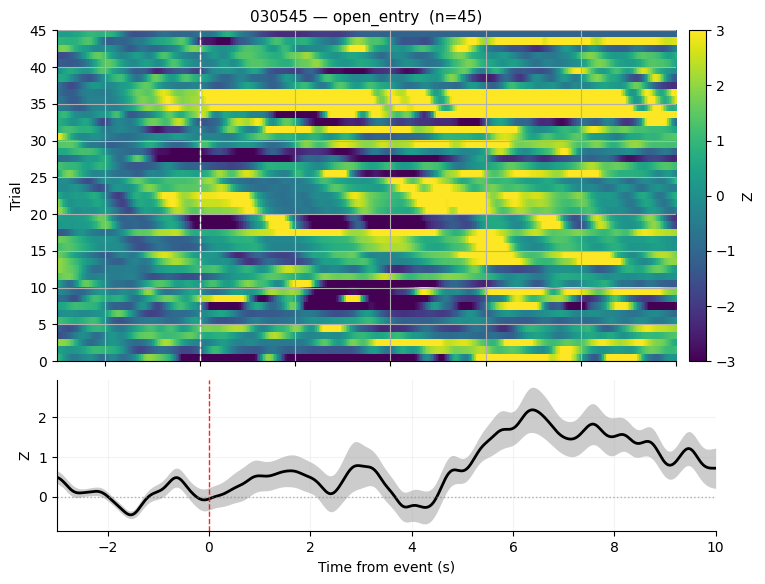

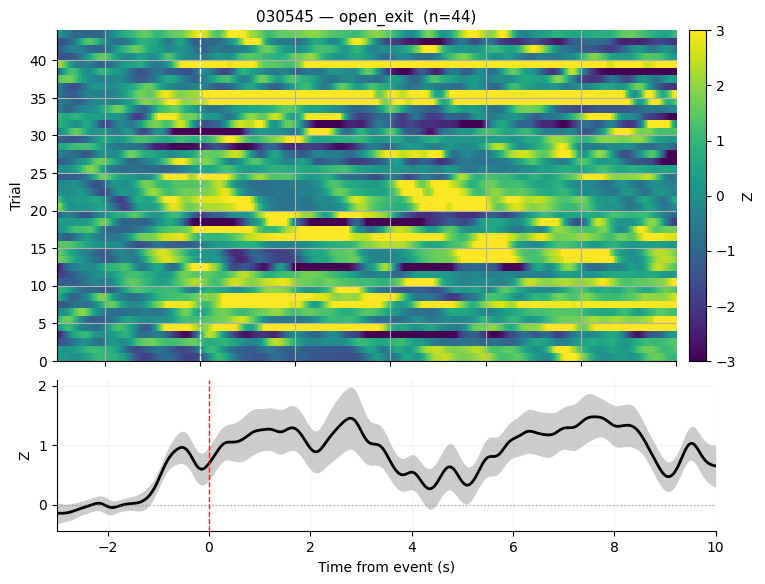

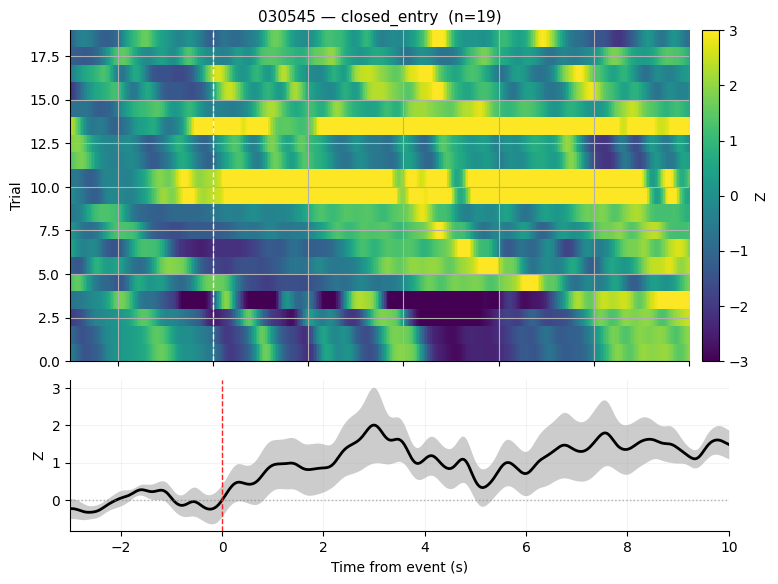

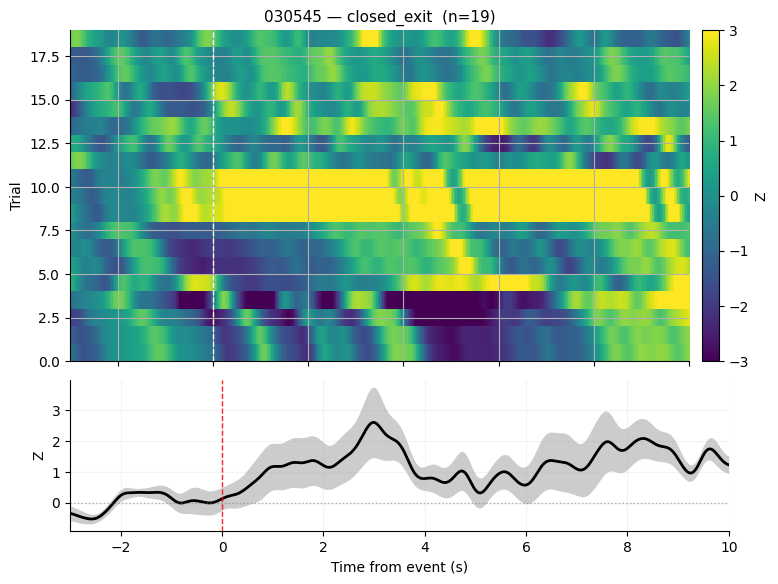

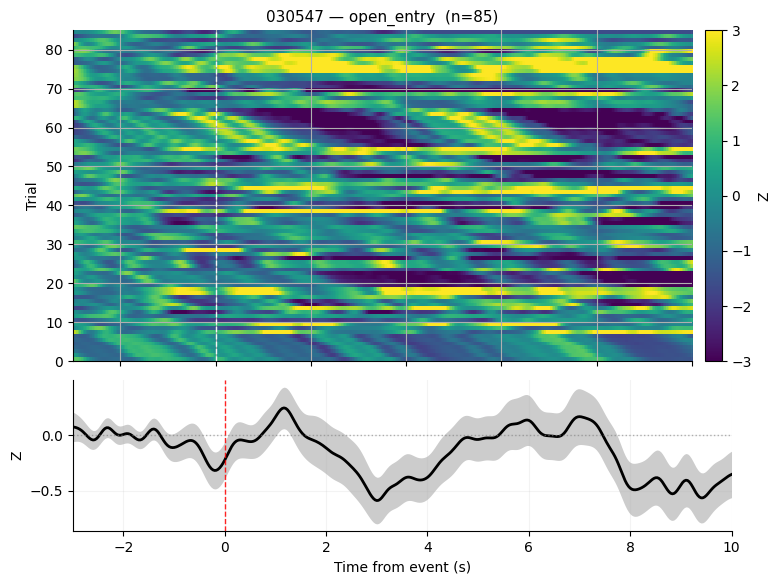

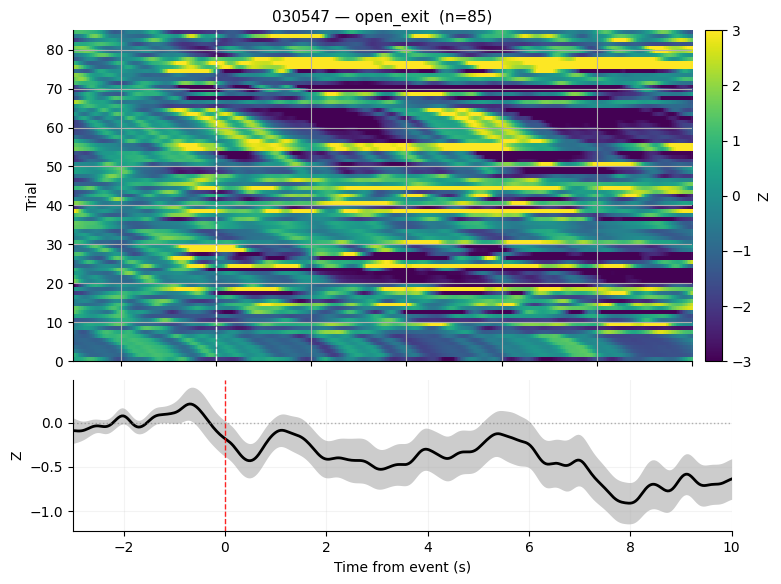

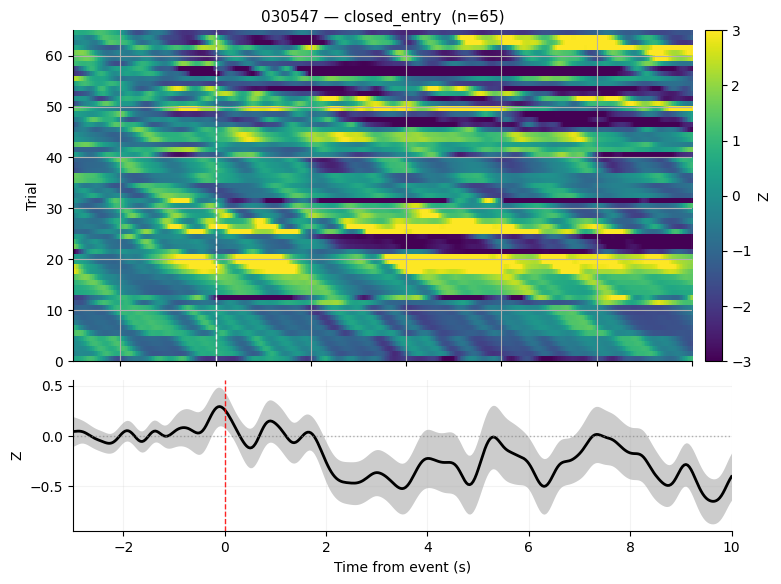

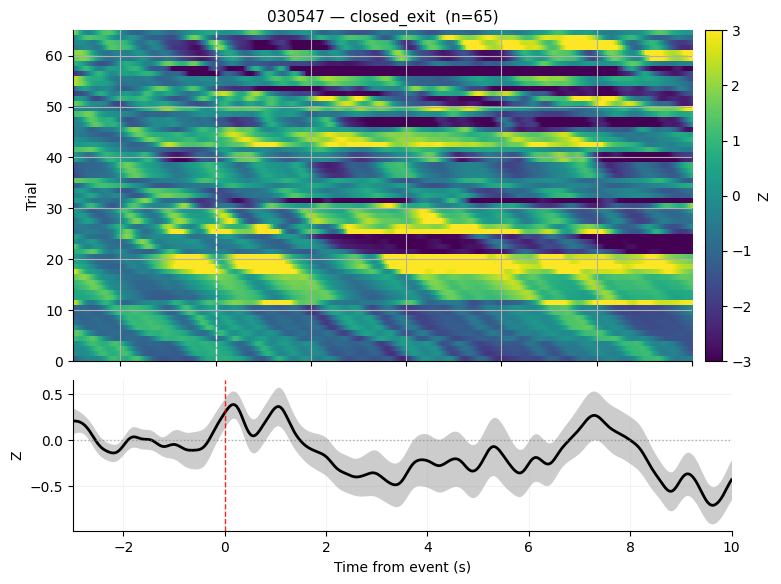

Done. PSTHs stored in epm_psth_results for 2 animals.


In [294]:
from scipy.ndimage import gaussian_filter1d  # needed by _compute_psth_matrix

# -----------------------------
# PSTH parameters
# -----------------------------
window = (-3, 10)
baseline_win = (-3, -1)
resample_hz = 30.0       # use 30 Hz (matches your target_fs and is clean for EPM)
smooth_sigma_s = 0.10

min_trials = 2
vmin, vmax = -3, 3
cmap = "viridis"

# Store psth outputs for later analysis
epm_psth_results = {}
# structure:
# epm_psth_results[animal_id][event_name] = {tvec, mat, mean, sem, n_trials, event_times}

# iterate per recording in epm_result_list
for rec in epm_result_list:
    animal_id = rec["animal"]
    beh = rec["behavior"]

    if "fiber_zscore_aligned" not in beh.columns:
        print(f"{animal_id}: missing fiber_zscore_aligned; skipping")
        continue

    t = beh["time"].to_numpy(dtype=float)
    y = beh["fiber_zscore_aligned"].to_numpy(dtype=float)

    # extract transition events (drop first event as requested)
    ev = extract_transition_events_epm(beh, thr=0.5, drop_first=True)

    # init container
    if animal_id not in epm_psth_results:
        epm_psth_results[animal_id] = {}

    # plot 4 event types for this animal
    for event_name in ["open_entry", "open_exit", "closed_entry", "closed_exit"]:
        event_times = ev[event_name]
        if event_times.size < min_trials:
            # store empty
            epm_psth_results[animal_id][event_name] = {
                "tvec": np.array([], float),
                "mat": np.zeros((0, 0), float),
                "mean": np.array([], float),
                "sem": np.array([], float),
                "n_trials": 0,
                "event_times": event_times,
            }
            continue

        tvec, mat = _compute_psth_matrix(
            t=t,
            y=y,
            event_times=event_times,
            window=window,
            baseline_win=baseline_win,
            resample_hz=resample_hz,
            smooth_sigma_s=smooth_sigma_s,
        )

        # drop all-NaN trials (bounds)
        mat = mat[~np.isnan(mat).all(axis=1)]
        n_trials = mat.shape[0]

        if n_trials < min_trials:
            epm_psth_results[animal_id][event_name] = {
                "tvec": tvec,
                "mat": mat,
                "mean": np.nanmean(mat, axis=0) if n_trials else np.array([], float),
                "sem": (np.nanstd(mat, axis=0) / np.sqrt(n_trials)) if n_trials else np.array([], float),
                "n_trials": n_trials,
                "event_times": event_times,
            }
            continue

        mean_trace = np.nanmean(mat, axis=0)
        sem_trace = np.nanstd(mat, axis=0) / np.sqrt(n_trials)

        epm_psth_results[animal_id][event_name] = {
            "tvec": tvec,
            "mat": mat,
            "mean": mean_trace,
            "sem": sem_trace,
            "n_trials": n_trials,
            "event_times": event_times,
        }

        # Plot
        plot_psth_heatmap_and_mean(
            tvec, mat,
            title=f"{animal_id} — {event_name}",
            vmin=vmin, vmax=vmax, cmap=cmap
        )

print(f"Done. PSTHs stored in epm_psth_results for {len(epm_psth_results)} animals.")


C:\Users\andrianj\AppData\Local\Temp\ipykernel_1356456\720554105.py:158: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


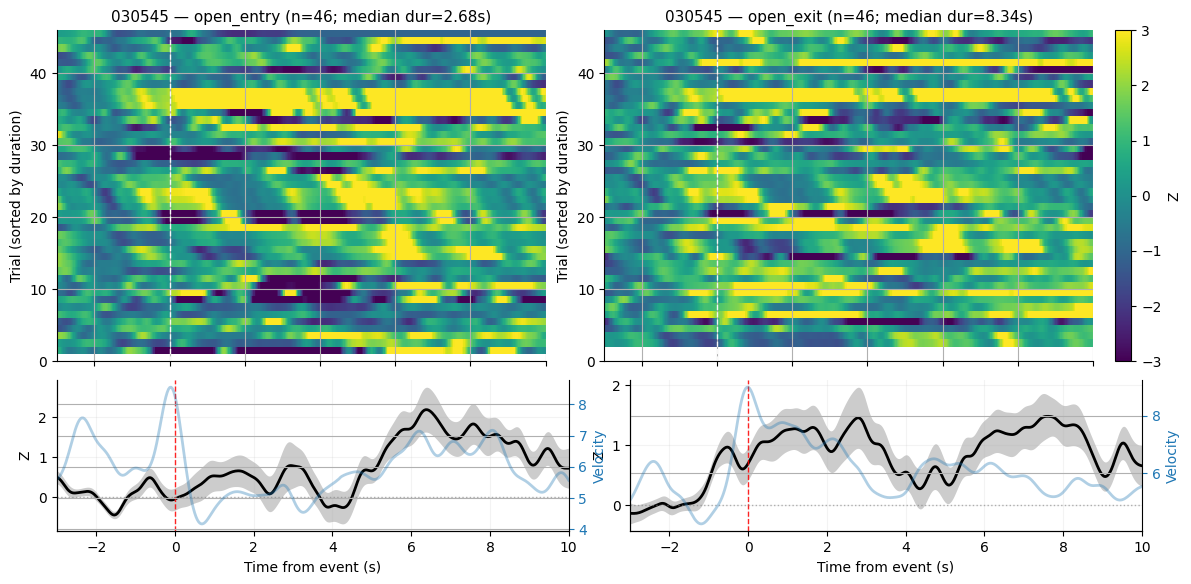

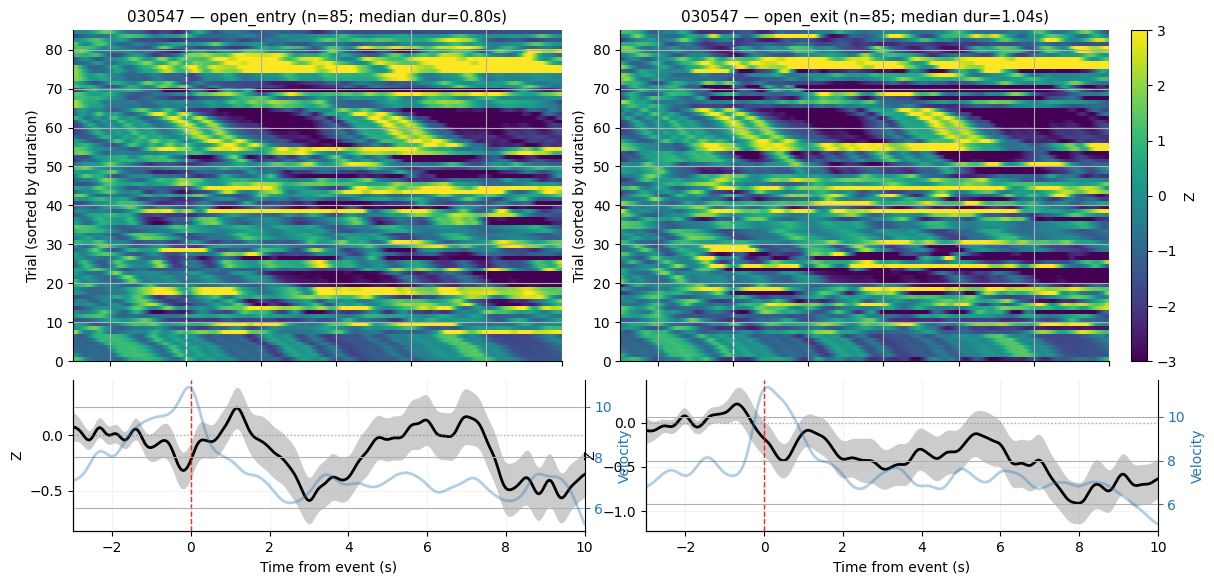

In [295]:
def compute_forward_durations(event_times, next_event_times):
    """
    For each event time, compute duration to the next event of another type.
    duration[i] = next_event_times[first index with next_event_times > event_times[i]] - event_times[i]
    Returns NaN if no subsequent event exists.
    """
    event_times = np.asarray(event_times, float)
    next_event_times = np.asarray(next_event_times, float)

    dur = np.full(event_times.shape, np.nan, dtype=float)
    if event_times.size == 0 or next_event_times.size == 0:
        return dur

    # next strictly greater event
    idx = np.searchsorted(next_event_times, event_times, side="right")
    ok = idx < next_event_times.size
    dur[ok] = next_event_times[idx[ok]] - event_times[ok]
    return dur


def _sort_trials_by_duration(mat, durations, vel_mat=None):
    """
    Sort rows (trials) by duration (ascending): shortest at bottom (origin='lower'), longest at top.
    Keeps matrices aligned; drops trials with NaN duration or all-NaN row.
    """
    if mat is None or mat.size == 0:
        return mat, durations, vel_mat

    mat = np.asarray(mat, float)
    durations = None if durations is None else np.asarray(durations, float)

    # drop all-NaN rows
    keep = ~np.isnan(mat).all(axis=1)

    if durations is not None:
        keep = keep & np.isfinite(durations)

    mat = mat[keep]
    if durations is not None:
        durations = durations[keep]
    if vel_mat is not None and getattr(vel_mat, "size", 0):
        vel_mat = vel_mat[keep]

    if durations is not None and mat.shape[0] > 1:
        order = np.argsort(durations)  # ascending
        mat = mat[order]
        durations = durations[order]
        if vel_mat is not None and getattr(vel_mat, "size", 0):
            vel_mat = vel_mat[order]

    return mat, durations, vel_mat
def plot_open_entry_exit_column_with_velocity(
    tvec,
    mat_entry,
    mat_exit,
    title_prefix="",
    vmin=-3, vmax=3, cmap="viridis",
    vel_tvec=None,
    vel_mat_entry=None,
    vel_mat_exit=None,
    vel_color="tab:blue",
    vel_alpha=0.35,
    # NEW: durations used to order heatmap trials
    dur_entry=None,
    dur_exit=None,
):
    """
    2x2 layout:
      Row 0: heatmaps (entry | exit) ordered by duration if provided
      Row 1: mean±SEM (entry | exit), with velocity overlay on twinx if provided
    """

    # sort trials by duration (also drops NaN-duration trials)
    # mat_entry, dur_entry, vel_mat_entry = _sort_trials_by_duration(mat_entry, dur_entry, vel_mat_entry)
    # mat_exit,  dur_exit,  vel_mat_exit  = _sort_trials_by_duration(mat_exit,  dur_exit,  vel_mat_exit)

    if (mat_entry is None or mat_entry.shape[0] == 0) and (mat_exit is None or mat_exit.shape[0] == 0):
        fig, ax = plt.subplots(figsize=(8, 2.0))
        ax.axis("off")
        ax.text(0.02, 0.5, f"{title_prefix}\n(no valid trials)", transform=ax.transAxes, va="center")
        plt.tight_layout()
        plt.show()
        return

    fig, axs = plt.subplots(
        2, 2, figsize=(14, 6.5), sharex=True,
        gridspec_kw={"height_ratios": [2.2, 1.0], "hspace": 0.08, "wspace": 0.12}
    )
    (ax_hm_e, ax_hm_x), (ax_mu_e, ax_mu_x) = axs

    # --- Heatmaps ---
    def _plot_hm(ax, mat, label, durations):
        if mat is None or mat.shape[0] == 0:
            ax.axis("off")
            ax.text(0.02, 0.5, f"{label}\n(no valid trials)", transform=ax.transAxes, va="center")
            return None

        im = ax.imshow(
            mat, aspect="auto", origin="lower",
            extent=[tvec[0], tvec[-1], 0, mat.shape[0]],
            cmap=cmap, vmin=vmin, vmax=vmax, interpolation="nearest"
        )
        ax.axvline(0, color="w", linestyle="--", lw=1, alpha=0.9)
        ax.set_ylabel("Trial (sorted by duration)")
        if durations is not None and durations.size:
            ax.set_title(
                f"{label} (n={mat.shape[0]}; median dur={np.nanmedian(durations):.2f}s)",
                fontsize=11
            )
        else:
            ax.set_title(f"{label} (n={mat.shape[0]})", fontsize=11)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        return im

    im1 = _plot_hm(ax_hm_e, mat_entry, f"{title_prefix} — open_entry", dur_entry)
    im2 = _plot_hm(ax_hm_x, mat_exit,  f"{title_prefix} — open_exit",  dur_exit)

    ims = [im for im in (im1, im2) if im is not None]
    if len(ims) > 0:
        cbar = fig.colorbar(ims[0], ax=[ax_hm_e, ax_hm_x], fraction=0.025, pad=0.02)
        cbar.set_label("Z", rotation=90)

    # --- Means + velocity overlay ---
    def _plot_mean(ax, mat, vel_mat, label):
        if mat is None or mat.shape[0] == 0:
            ax.axis("off")
            ax.text(0.02, 0.5, f"{label}\n(no valid trials)", transform=ax.transAxes, va="center")
            return

        mean_trace = np.nanmean(mat, axis=0)
        sem_trace  = np.nanstd(mat, axis=0) / np.sqrt(mat.shape[0])

        ax.plot(tvec, mean_trace, lw=2.0, color="k")
        ax.fill_between(tvec, mean_trace - sem_trace, mean_trace + sem_trace,
                        color="k", alpha=0.2, linewidth=0)
        ax.axvline(0, color="r", linestyle="--", lw=1, alpha=0.85)
        ax.axhline(0, color="gray", linestyle=":", lw=1, alpha=0.6)
        ax.set_xlabel("Time from event (s)")
        ax.set_ylabel("Z")
        ax.grid(True, alpha=0.15)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

        if vel_tvec is not None and vel_mat is not None and getattr(vel_mat, "size", 0):
            vel_mat = vel_mat[~np.isnan(vel_mat).all(axis=1)]
            if vel_mat.shape[0] > 0:
                vmean = np.nanmean(vel_mat, axis=0)
                vax = ax.twinx()
                vax.plot(vel_tvec, vmean, color=vel_color, lw=2.0, alpha=vel_alpha)
                vax.set_ylabel("Velocity", color=vel_color)
                vax.tick_params(axis="y", colors=vel_color)
                vax.spines["top"].set_visible(False)

    _plot_mean(ax_mu_e, mat_entry, vel_mat_entry, "open_entry")
    _plot_mean(ax_mu_x, mat_exit,  vel_mat_exit,  "open_exit")

    plt.tight_layout()
    plt.show()
# In your loop: compute duration per trial and pass into the plot call
for rec in epm_result_list:
    animal_id = rec["animal"]
    beh = rec["behavior"]

    if "fiber_zscore_aligned" not in beh.columns:
        print(f"{animal_id}: missing fiber_zscore_aligned; skipping")
        continue

    # clean velocity first (so _find_velocity_column sees final column)
    beh = clean_velocity_data(beh)

    t = beh["time"].to_numpy(dtype=float)
    y = beh["fiber_zscore_aligned"].to_numpy(dtype=float)

    ev = extract_transition_events_epm(beh, thr=0.5, drop_first=True)

    vel_col = _find_velocity_column(beh)
    vel = beh[vel_col].to_numpy(dtype=float) if vel_col is not None else None

    # durations (for sorting heatmap trials)
    dur_open_entry = compute_forward_durations(ev["open_entry"], ev["open_exit"])  # open-bout durations
    dur_open_exit  = compute_forward_durations(ev["open_exit"],  ev["open_entry"]) # closed-bout durations

    # compute PSTHs for open_entry and open_exit + velocity matrices
    results_pair = {}
    vel_pair = {}

    for event_name in ["open_entry", "open_exit"]:
        event_times = ev[event_name]

        if event_times.size < min_trials:
            results_pair[event_name] = (np.array([], float), np.zeros((0, 0), float))
            vel_pair[event_name] = (None, None)
            continue

        # fiber (your existing function)
        tvec, mat = _compute_psth_matrix(
            t=t, y=y,
            event_times=event_times,
            window=window,
            baseline_win=baseline_win,
            resample_hz=resample_hz,
            smooth_sigma_s=smooth_sigma_s,
        )
        results_pair[event_name] = (tvec, mat)

        # velocity matrix (no baseline z-scoring; smoothed)
        if vel is not None:
            vel_tvec, vel_mat = _compute_event_locked_matrix(
                t=t, y=vel,
                event_times=event_times,
                window=window,
                resample_hz=resample_hz,
                smooth_sigma_s=0.20,
            )
        else:
            vel_tvec, vel_mat = None, None

        vel_pair[event_name] = (vel_tvec, vel_mat)

    # unpack
    tvec_e, mat_e = results_pair["open_entry"]
    tvec_x, mat_x = results_pair["open_exit"]

    tvec_plot = tvec_e if tvec_e.size else tvec_x

    vel_tvec_e, vel_mat_e = vel_pair["open_entry"]
    vel_tvec_x, vel_mat_x = vel_pair["open_exit"]

    # IMPORTANT: durations need to align to the event_times used for each matrix.
    # Here they do, because dur_open_entry and dur_open_exit were computed from ev arrays.

    plot_open_entry_exit_column_with_velocity(
        tvec=tvec_plot,
        mat_entry=mat_e,
        mat_exit=mat_x,
        title_prefix=animal_id,
        vmin=vmin, vmax=vmax, cmap=cmap,
        vel_tvec=vel_tvec_e if vel_tvec_e is not None else None,  # same grid expected
        vel_mat_entry=vel_mat_e,
        vel_mat_exit=vel_mat_x,
        vel_color="tab:blue",
        vel_alpha=0.35,
        dur_entry=dur_open_entry,
        dur_exit=dur_open_exit,
    )


C:\Users\andrianj\AppData\Local\Temp\ipykernel_1356456\720554105.py:158: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


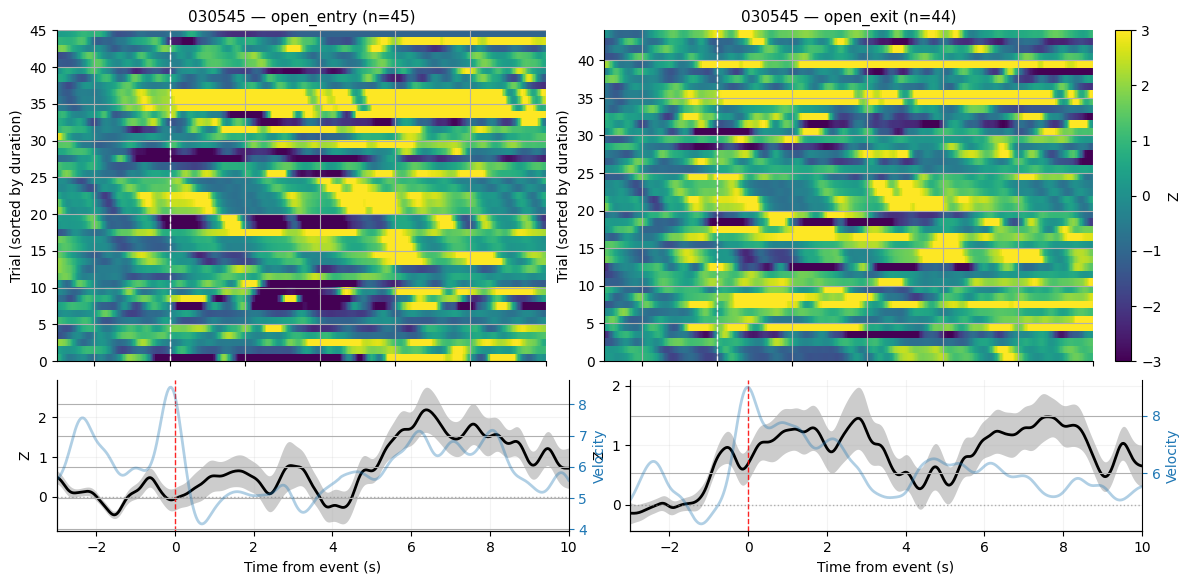

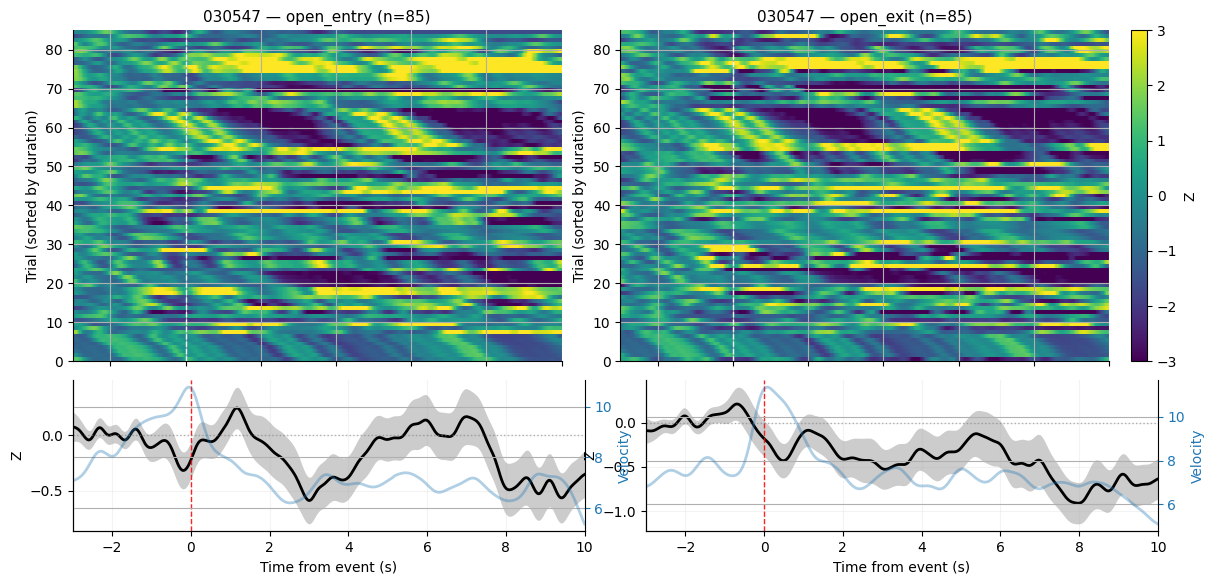

In [296]:
# -----------------------------
# Drop-in usage inside your loop
# -----------------------------
# Make sure you have a velocity column (or adjust the candidates list in _find_velocity_column)

for rec in epm_result_list:
    animal_id = rec["animal"]
    beh = rec["behavior"]

    if "fiber_zscore_aligned" not in beh.columns:
        print(f"{animal_id}: missing fiber_zscore_aligned; skipping")
        continue

    t = beh["time"].to_numpy(dtype=float)
    y = beh["fiber_zscore_aligned"].to_numpy(dtype=float)

    # extract transition events
    ev = extract_transition_events_epm(beh, thr=0.5, drop_first=True)

    # velocity (optional)
    vel_col = _find_velocity_column(beh)
    beh=clean_velocity_data(beh)
    vel = beh[vel_col].to_numpy(dtype=float) if vel_col is not None else None

    # compute fiber PSTHs for open_entry and open_exit
    results_pair = {}
    vel_pair = {}

    for event_name in ["open_entry", "open_exit"]:
        event_times = ev[event_name]

        if event_times.size < min_trials:
            results_pair[event_name] = (np.array([], float), np.zeros((0, 0), float))
            vel_pair[event_name] = (np.array([], float), np.zeros((0, 0), float))
            continue

        # fiber (your existing function)
        tvec, mat = _compute_psth_matrix(
            t=t, y=y,
            event_times=event_times,
            window=window,
            baseline_win=baseline_win,
            resample_hz=resample_hz,
            smooth_sigma_s=smooth_sigma_s,
        )
        mat = mat[~np.isnan(mat).all(axis=1)]
        results_pair[event_name] = (tvec, mat)

        # velocity matrix (no baseline z-scoring; smoothed)
        if vel is not None:
            vel_tvec, vel_mat = _compute_event_locked_matrix(
                t=t, y=vel,
                event_times=event_times,
                window=window,
                resample_hz=resample_hz,
                smooth_sigma_s=0.20,  # slightly more smoothing often looks better for velocity
            )
        else:
            vel_tvec, vel_mat = None, None

        vel_pair[event_name] = (vel_tvec, vel_mat)

    # unpack
    tvec_e, mat_e = results_pair["open_entry"]
    tvec_x, mat_x = results_pair["open_exit"]

    # ensure consistent tvec (should be identical if same params)
    if tvec_e.size and tvec_x.size and not np.allclose(tvec_e, tvec_x, equal_nan=True):
        print(f"{animal_id}: warning — tvec differs between entry/exit; using entry tvec.")
    tvec_plot = tvec_e if tvec_e.size else tvec_x

    vel_tvec_e, vel_mat_e = vel_pair["open_entry"]
    vel_tvec_x, vel_mat_x = vel_pair["open_exit"]

    # plot both as columns in a single figure (+ velocity overlay on mean plots)
    plot_open_entry_exit_column_with_velocity(
        tvec=tvec_plot,
        mat_entry=mat_e if mat_e.size else np.zeros((0, tvec_plot.size)),
        mat_exit=mat_x if mat_x.size else np.zeros((0, tvec_plot.size)),
        title_prefix=animal_id,
        vmin=vmin, vmax=vmax, cmap=cmap,
        vel_tvec=vel_tvec_e if vel_tvec_e is not None else None,   # same grid expected
        vel_mat_entry=vel_mat_e,
        vel_mat_exit=vel_mat_x,
        vel_color="tab:blue",
        vel_alpha=0.35,
    )


In [297]:
import numpy as np
import matplotlib.pyplot as plt

def compute_unwarped_psth_for_event(
    beh_df,
    event_times,
    *,
    fiber_col="fiber_zscore_aligned",
    window=(-3, 5),
    baseline_win=(-3, 0),
    resample_hz=30.0,
    smooth_sigma_s=0.08,
    min_trials=3,
):
    """
    Returns:
      tvec, mat  (trials x time)
    """
    t = beh_df["time"].to_numpy(dtype=float)
    y = beh_df[fiber_col].to_numpy(dtype=float)

    ev = np.asarray(event_times, float)
    ev = ev[np.isfinite(ev)]
    if ev.size < min_trials:
        return np.array([], float), np.zeros((0, 0), float)

    tvec, mat = _compute_psth_matrix(
        t=t, y=y, event_times=ev,
        window=window,
        baseline_win=baseline_win,
        resample_hz=float(resample_hz),
        smooth_sigma_s=float(smooth_sigma_s),
    )

    # drop fully-NaN rows (boundary coverage)
    if mat.size:
        keep = ~np.isnan(mat).all(axis=1)
        mat = mat[keep]

    if mat.shape[0] < min_trials:
        return np.array([], float), np.zeros((0, 0), float)

    return tvec, mat


In [298]:
import numpy as np
import matplotlib.pyplot as plt

def plot_unwarped_sanity_check_per_animal(
    animal_id,
    beh_df,
    tw_cycle,
    *,
    events=("entry", "return", "next_entry"),
    event_titles=None,
    fiber_col="fiber_zscore_aligned",
    window=(-3, 5),
    baseline_win=(-3, 0),
    resample_hz=30.0,
    smooth_sigma_s=0.08,
    min_trials=3,
    stratify_by_open_duration=True,
    duration_split="median",  # or provide a float threshold
    cmap="viridis",
    vmin=None,
    vmax=None,
    pct_limits=(2, 98),
    figsize=(16, 7.5),
):
    """
    events: tuple of {"entry","return","next_entry"} corresponding to tw_cycle keys.
    Uses the SAME bout list as tw_cycle (already dropped first event etc).
    """
    if tw_cycle is None:
        print(f"{animal_id}: tw_cycle is None; skipping sanity check.")
        return

    if "time" not in beh_df.columns or fiber_col not in beh_df.columns:
        print(f"{animal_id}: missing time or {fiber_col} in behavior df.")
        return

    # bout-defining times from time-warp cycle extraction
    entry_s = np.asarray(tw_cycle["entry_s"], float)
    ret_s   = np.asarray(tw_cycle["return_s"], float)
    next_s  = np.asarray(tw_cycle["next_entry_s"], float)
    open_dur = np.asarray(tw_cycle["open_dur_s"], float)

    # choose event time arrays in the same bout order
    event_map = {
        "entry": entry_s,
        "return": ret_s,
        "next_entry": next_s,
    }

    if event_titles is None:
        event_titles = {
            "entry": "Open entry (true time)",
            "return": "Return to closed (true time)",
            "next_entry": "Next open entry (true time)",
        }

    # duration stratification (short vs long)
    if stratify_by_open_duration and open_dur.size >= 2:
        if duration_split == "median":
            thr = float(np.nanmedian(open_dur))
        else:
            thr = float(duration_split)

        is_short = open_dur <= thr
        is_long  = open_dur > thr
        # sort by duration for heatmap readability
        order = np.argsort(open_dur)
    else:
        thr = np.nan
        is_short = None
        is_long = None
        order = np.arange(open_dur.size)

    # figure grid: 2 rows (heatmap + mean) x n_events columns
    nE = len(events)
    fig = plt.figure(figsize=figsize, constrained_layout=False)
    gs = fig.add_gridspec(
        nrows=2, ncols=nE,
        height_ratios=[2.25, 1.05],
        wspace=0.18, hspace=0.08
    )

    # collect images for shared colorbar
    heatmap_images = []

    fig.suptitle(
        f"{animal_id} — sanity check (non-warped PSTHs in true seconds)\n"
        f"Trials match time-warp cycles; sorted by open duration"
        + (f" (median split @ {thr:.2f}s)" if np.isfinite(thr) else ""),
        y=0.98, fontsize=13
    )

    for j, ev_name in enumerate(events):
        ax_hm = fig.add_subplot(gs[0, j])
        ax_mu = fig.add_subplot(gs[1, j], sharex=ax_hm)

        # event times in bout order -> reorder for plotting
        ev_times = np.asarray(event_map[ev_name], float)
        ev_times = ev_times[order]

        # compute PSTH on ALL bouts for this event
        tvec, mat = compute_unwarped_psth_for_event(
            beh_df, ev_times,
            fiber_col=fiber_col,
            window=window,
            baseline_win=baseline_win,
            resample_hz=resample_hz,
            smooth_sigma_s=smooth_sigma_s,
            min_trials=min_trials,
        )

        if mat.size == 0:
            ax_hm.axis("off")
            ax_mu.axis("off")
            ax_hm.text(0.5, 0.5, f"{event_titles.get(ev_name, ev_name)}\n(no data)",
                       ha="center", va="center", transform=ax_hm.transAxes)
            continue

        # color scaling (optionally percentile-based)
        finite = mat[np.isfinite(mat)]
        if finite.size == 0:
            vvmin, vvmax = -1, 1
        else:
            if vmin is None or vmax is None:
                lo, hi = np.nanpercentile(finite, pct_limits)
                m = max(abs(lo), abs(hi), 1e-6)
                vvmin, vvmax = -m, m
            else:
                vvmin, vvmax = float(vmin), float(vmax)

        # heatmap
        im = ax_hm.imshow(
            mat,
            aspect="auto",
            origin="lower",
            extent=[tvec[0], tvec[-1], 0, mat.shape[0]],
            cmap=cmap,
            vmin=vvmin, vmax=vvmax,
            interpolation="nearest"
        )
        heatmap_images.append(im)

        # alignment markers
        ax_hm.axvline(0, color="w", linestyle="--", lw=1.4, alpha=0.95)
        ax_hm.set_title(f"{event_titles.get(ev_name, ev_name)}\n(n={mat.shape[0]})", fontsize=11, pad=6)
        if j == 0:
            ax_hm.set_ylabel("Bout", fontsize=10)
        else:
            ax_hm.set_ylabel("")
            ax_hm.tick_params(labelleft=False)

        ax_hm.spines["top"].set_visible(False)
        ax_hm.spines["right"].set_visible(False)
        ax_hm.grid(False)

        # if stratified, add horizontal divider between short/long (after sorting)
        if stratify_by_open_duration and is_short is not None:
            # compute split index in sorted order
            is_short_sorted = is_short[order]
            n_short = int(np.sum(is_short_sorted))
            if 0 < n_short < mat.shape[0]:
                ax_hm.axhline(n_short, color="w", lw=1.2, alpha=0.9)

        # mean ± SEM overall
        mu_all = np.nanmean(mat, axis=0)
        sem_all = np.nanstd(mat, axis=0) / np.sqrt(mat.shape[0])

        ax_mu.axvline(0, color="k", linestyle="--", lw=1.0, alpha=0.55)
        ax_mu.axhline(0, color="gray", linestyle=":", lw=1.0, alpha=0.6)

        # stratified means (short vs long)
        if stratify_by_open_duration and is_short is not None:
            # map the same split onto the matrix rows (already sorted)
            is_short_sorted = is_short[order]
            is_long_sorted = is_long[order]

            if np.sum(is_short_sorted) >= min_trials:
                mat_s = mat[is_short_sorted]
                mu_s = np.nanmean(mat_s, axis=0)
                sem_s = np.nanstd(mat_s, axis=0) / np.sqrt(mat_s.shape[0])
                ax_mu.plot(tvec, mu_s, lw=1.8, label=f"Short (n={mat_s.shape[0]})")
                ax_mu.fill_between(tvec, mu_s - sem_s, mu_s + sem_s, alpha=0.18, linewidth=0)

            if np.sum(is_long_sorted) >= min_trials:
                mat_l = mat[is_long_sorted]
                mu_l = np.nanmean(mat_l, axis=0)
                sem_l = np.nanstd(mat_l, axis=0) / np.sqrt(mat_l.shape[0])
                ax_mu.plot(tvec, mu_l, lw=1.8, label=f"Long (n={mat_l.shape[0]})")
                ax_mu.fill_between(tvec, mu_l - sem_l, mu_l + sem_l, alpha=0.18, linewidth=0)

            # also plot overall thin
            ax_mu.plot(tvec, mu_all, color="k", lw=1.2, alpha=0.75, label="All")
            ax_mu.fill_between(tvec, mu_all - sem_all, mu_all + sem_all, color="k", alpha=0.10, linewidth=0)

            ax_mu.legend(frameon=False, fontsize=8, loc="upper right")
        else:
            ax_mu.plot(tvec, mu_all, color="k", lw=2.0)
            ax_mu.fill_between(tvec, mu_all - sem_all, mu_all + sem_all, color="k", alpha=0.18, linewidth=0)

        ax_mu.set_xlim(window[0], window[1])
        ax_mu.set_xlabel("Time from event (s)", fontsize=10)
        if j == 0:
            ax_mu.set_ylabel("Z", fontsize=10)
        else:
            ax_mu.set_ylabel("")
        ax_mu.grid(True, alpha=0.10)
        ax_mu.spines["top"].set_visible(False)
        ax_mu.spines["right"].set_visible(False)

        plt.setp(ax_hm.get_xticklabels(), visible=False)

    # One shared colorbar (cleaner)
    if heatmap_images:
        cbar = fig.colorbar(
            heatmap_images[0],
            ax=fig.axes,
            fraction=0.018,
            pad=0.01,
            shrink=0.92
        )
        cbar.set_label("Baseline-normalized Z", fontsize=10)
        cbar.ax.tick_params(labelsize=9, length=2)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


C:\Users\andrianj\AppData\Local\Temp\ipykernel_1356456\376064105.py:224: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


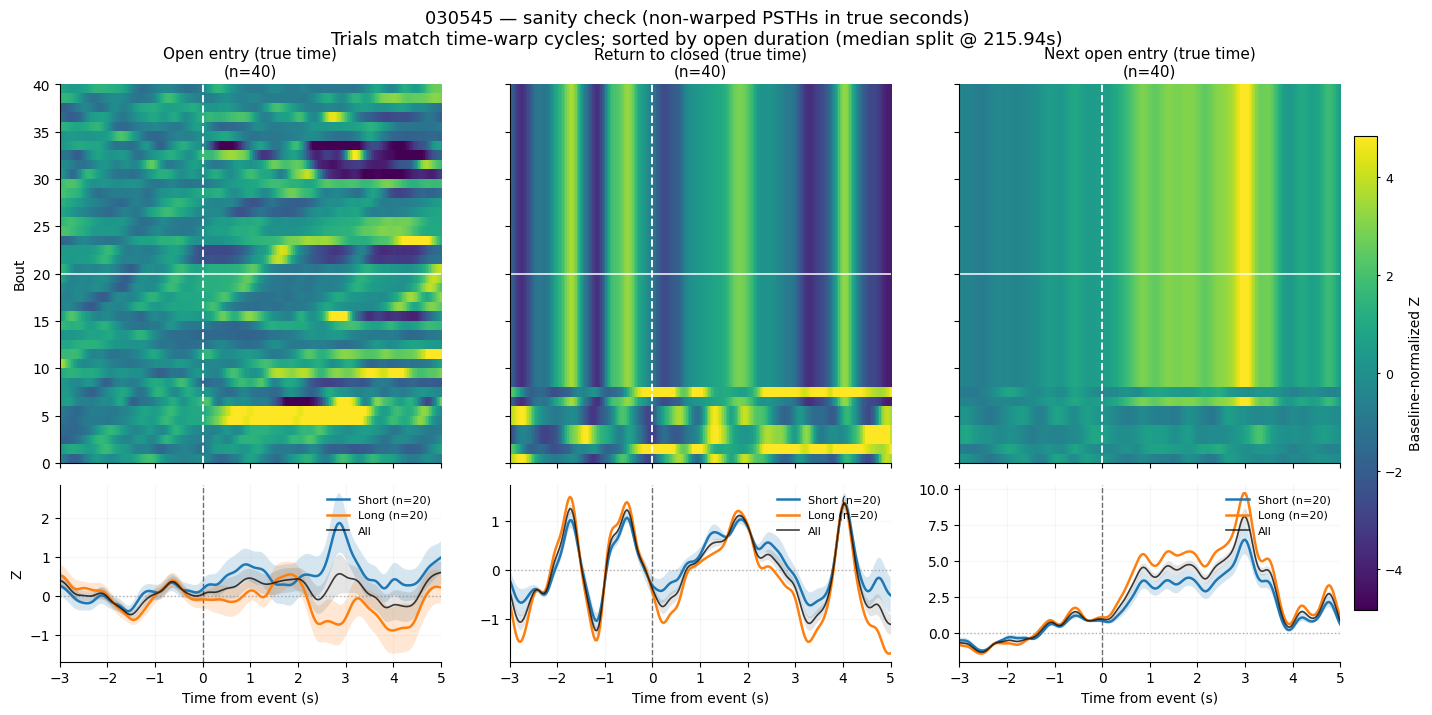

030547: tw_cycle is None; skipping sanity check.


In [299]:
# Parameters for PSTH sanity check
psth_window = (-3, 5)
psth_baseline = (-3, 0)
resample_hz = 30.0

for rec in epm_result_list:
    animal_id = rec["animal"]
    beh_df = rec["behavior"]
    tw = epm_timewarp_cycle_results.get(animal_id, None)

    plot_unwarped_sanity_check_per_animal(
        animal_id,
        beh_df,
        tw,
        events=("entry", "return", "next_entry"),  # columns
        window=psth_window,
        baseline_win=psth_baseline,
        resample_hz=resample_hz,
        smooth_sigma_s=0.08,
        min_trials=3,
        stratify_by_open_duration=True,
        duration_split="median",
        figsize=(17, 7.5),
    )


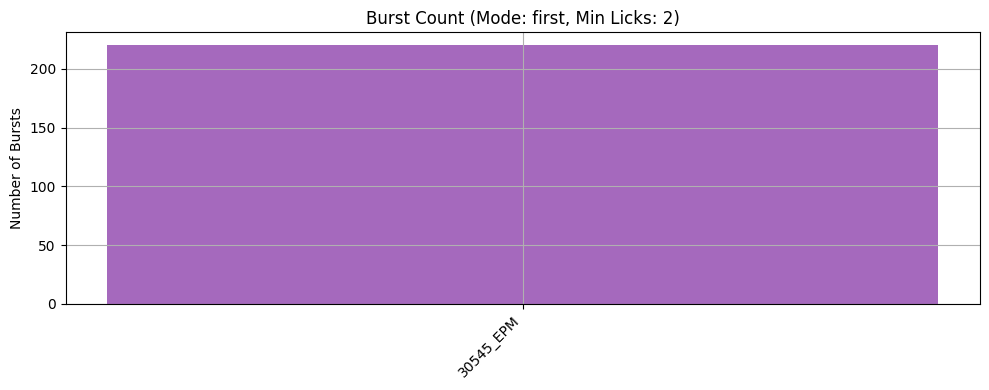

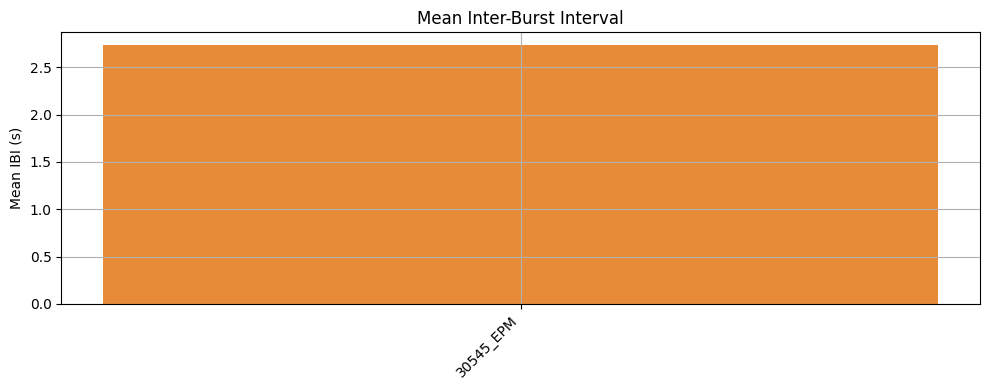

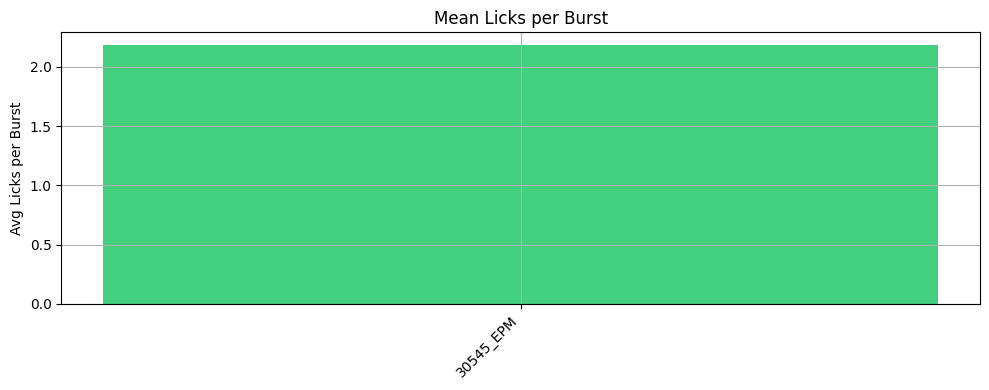

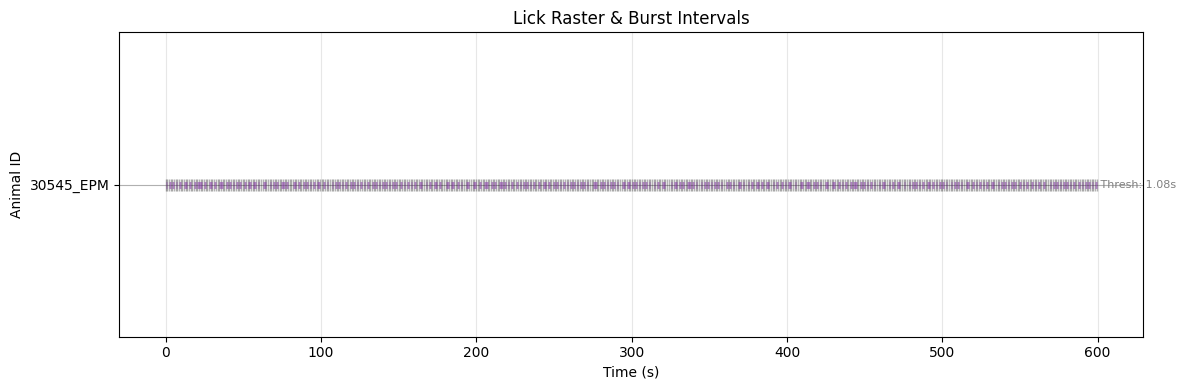

In [300]:
import numpy as np
import matplotlib.pyplot as plt

# ---- User Options ----
PLOT_WINDOW = None          # [start_s, end_s] or None for full session
DIO_THRESHOLD = 0.5         # Voltage threshold for digital IO
MIN_EVENT_GAP_S = 0.2      # Debounce: ignore events closer than 20ms
BOUT_GAP_S = "auto"         # New burst if IEI > this (seconds). "auto" uses log-KMeans.
MIN_LICKS_PER_BURST = 2     # Minimum licks to count as a valid burst

# Burst Alignment Mode for 'burst_t':
# "first"  : Aligns to the very first lick
# "second" : Aligns to the second lick
BURST_EVENT_MODE = "first"

def apply_window(t: np.ndarray, *series: np.ndarray, plot_window=None):
    """Restricts time and data arrays to a specific time window."""
    if plot_window is None:
        mask = np.ones_like(t, dtype=bool)
        return (t, *series, mask)

    lo, hi = float(plot_window[0]), float(plot_window[1])
    if lo > hi: lo, hi = hi, lo

    mask = (t >= lo) & (t <= hi)
    t_masked = t[mask]
    series_masked = [s[mask] if s is not None else None for s in series]
    return (t_masked, *series_masked, mask)

def detect_lick_times(t: np.ndarray, dio: np.ndarray, threshold=0.5, min_event_gap_s=0.02):
    """Converts raw analog DIO signal into discrete timestamps with debouncing."""
    t = np.asarray(t, float)
    x = np.asarray(dio, float)
    if t.size == 0 or x.size == 0:
        return np.array([], dtype=float)

    binary = x >= float(threshold)
    rising_indices = np.flatnonzero(np.diff(binary.astype(np.int8), prepend=binary[0].astype(np.int8)) == 1)
    lick_t = t[rising_indices].astype(float)

    if lick_t.size <= 1:
        return lick_t

    # Debounce
    dt = np.diff(lick_t)
    keep = np.ones_like(lick_t, dtype=bool)
    keep[1:] = dt >= float(min_event_gap_s)

    return lick_t[keep]

def get_burst_threshold(lick_t: np.ndarray, bout_gap_s="auto"):
    """Calculates the burst separation threshold using log-KMeans if 'auto'."""
    if lick_t.size < 2:
        return 0.5 if bout_gap_s == "auto" else float(bout_gap_s)

    if bout_gap_s != "auto":
        return float(bout_gap_s)

    iei = np.diff(lick_t)
    valid_iei = iei[(iei > 0) & (iei < 60)]

    if valid_iei.size <= 5:
        return 0.5

    log_iei = np.log10(valid_iei)
    c1 = np.percentile(log_iei, 20)
    c2 = np.percentile(log_iei, 80)

    for _ in range(10):
        d1 = np.abs(log_iei - c1)
        d2 = np.abs(log_iei - c2)
        mask1 = d1 < d2
        if np.any(mask1): c1 = np.mean(log_iei[mask1])
        if np.any(~mask1): c2 = np.mean(log_iei[~mask1])

    split_log = (c1 + c2) / 2.0
    calc_thresh = 10**split_log

    return max(0.2, min(calc_thresh, 5.0))

def burst_events_from_licks(lick_t: np.ndarray, bout_gap_s="auto", mode="first", min_licks=1):
    """
    Groups licks into bursts.
    Returns:
      burst_times: Main alignment timestamp (based on 'mode')
      burst_sizes: Count of licks in each burst
      ibi: Inter-burst intervals
      threshold: The gap threshold used
      onset_second_lick: Specific timestamp of the 2nd lick for every burst (NaN if size < 2)
    """
    lick_t = np.asarray(lick_t, float)
    if lick_t.size == 0:
        return np.array([]), np.array([], dtype=int), np.array([]), 0.5, np.array([])

    # 1. Threshold
    threshold = get_burst_threshold(lick_t, bout_gap_s)

    # 2. Grouping
    iei = np.diff(lick_t)
    new_burst = np.r_[True, iei > threshold]
    burst_ids = np.cumsum(new_burst) - 1

    unique_bursts = np.unique(burst_ids)

    burst_times = []
    burst_sizes = []
    onset_second_lick = [] # New collection list

    # 3. Filtering & Timestamping
    for b in unique_bursts:
        lt = lick_t[burst_ids == b]
        n_licks = lt.size

        if n_licks < min_licks:
            continue

        # Determine Main Alignment Timestamp
        timestamp = np.nan
        if mode == "first":
            timestamp = lt[0]
        elif mode == "second":
            if n_licks >= 2:
                timestamp = lt[1]
            else:
                continue
        elif mode == "center":
            timestamp = np.mean(lt)

        # Determine "Second Lick" Timestamp (Always capture if available)
        second_val = lt[1] if n_licks >= 2 else np.nan

        burst_times.append(timestamp)
        burst_sizes.append(n_licks)
        onset_second_lick.append(second_val)

    burst_times = np.array(burst_times, dtype=float)
    burst_sizes = np.array(burst_sizes, dtype=int)
    onset_second_lick = np.array(onset_second_lick, dtype=float)

    ibi = np.diff(burst_times) if burst_times.size >= 2 else np.array([])

    return burst_times, burst_sizes, ibi, threshold, onset_second_lick

# ---- Main Analysis Loop ----
if 'results' not in locals():
    results = {}
    print("Warning: 'results' dictionary not found. Please load your data first.")

per_animal = {}

for animal_id, rec in results.items():
    t = rec["t"]
    dio = rec["dio2"]

    t_w, dio_w, _ = apply_window(t, dio, plot_window=PLOT_WINDOW)

    lick_t = detect_lick_times(
        t_w, dio_w, threshold=DIO_THRESHOLD, min_event_gap_s=MIN_EVENT_GAP_S
    )

    # Updated unpacking to include lick_onset (second lick)
    burst_t, burst_sizes, ibi, calc_thresh, lick_onset_2nd = burst_events_from_licks(
        lick_t, bout_gap_s=BOUT_GAP_S, mode=BURST_EVENT_MODE, min_licks=MIN_LICKS_PER_BURST
    )

    per_animal[animal_id] = {
        "n_bursts": int(burst_t.size),
        "burst_t": burst_t,            # Primary alignment timestamp
        "lick_onset": lick_onset_2nd,  # Timestamp of the 2nd lick (requested feature)
        "ibi": ibi,
        "burst_sizes": burst_sizes,
        "lick_t": lick_t,
        "calc_thresh": calc_thresh
    }

# ---- Visualization ----
if len(per_animal) > 0:
    animal_ids = sorted(per_animal.keys())

    # --- Plot 1: Burst Counts ---
    n_bursts = [per_animal[a]["n_bursts"] for a in animal_ids]

    plt.figure(figsize=(10, 4))
    plt.bar(animal_ids, n_bursts, color="#9b59b6", alpha=0.9)
    plt.ylabel("Number of Bursts")
    plt.title(f"Burst Count (Mode: {BURST_EVENT_MODE}, Min Licks: {MIN_LICKS_PER_BURST})")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    # --- Plot 2: Mean IBI (Inter-Burst Interval) ---
    mean_ibis = []
    for a in animal_ids:
        ibis = per_animal[a]["ibi"]
        val = np.nanmean(ibis) if ibis.size > 0 else np.nan
        mean_ibis.append(val)

    plt.figure(figsize=(10, 4))
    plt.bar(animal_ids, mean_ibis, color="#e67e22", alpha=0.9)
    plt.ylabel("Mean IBI (s)")
    plt.title("Mean Inter-Burst Interval")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    # --- Plot 3: Mean Licks Per Burst (NEW) ---
    mean_licks = []
    for a in animal_ids:
        sizes = per_animal[a]["burst_sizes"]
        val = np.mean(sizes) if sizes.size > 0 else 0
        mean_licks.append(val)

    plt.figure(figsize=(10, 4))
    plt.bar(animal_ids, mean_licks, color="#2ecc71", alpha=0.9) # Green
    plt.ylabel("Avg Licks per Burst")
    plt.title("Mean Licks per Burst")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    # --- Plot 4: Raster with Burst Overlays ---
    plt.figure(figsize=(12, max(4, len(animal_ids) * 0.8)))

    for i, animal_id in enumerate(animal_ids):
        data = per_animal[animal_id]
        lick_t = data["lick_t"]
        thresh = data["calc_thresh"]

        if lick_t.size == 0:
            continue

        iei = np.diff(lick_t)
        is_new_burst = np.r_[True, iei > thresh]
        burst_ids = np.cumsum(is_new_burst) - 1

        # Ticks
        plt.plot(lick_t, np.full_like(lick_t, i), '|', color='black',
                 markersize=8, markeredgewidth=1, alpha=0.3)

        # Bars
        unique_bursts = np.unique(burst_ids)
        for bid in unique_bursts:
            mask = burst_ids == bid
            ts = lick_t[mask]

            if len(ts) < MIN_LICKS_PER_BURST:
                continue

            t_start, t_end = ts[0], ts[-1]

            if t_end > t_start:
                plt.hlines(i, t_start, t_end, color='#8e44ad', linewidth=5, alpha=0.6)
            else:
                plt.plot(t_start, i, 'o', color='#8e44ad', markersize=4, alpha=0.6)

        plt.text(lick_t.max(), i, f" Thresh: {thresh:.2f}s", va='center', fontsize=8, color='gray')

    plt.yticks(range(len(animal_ids)), animal_ids)
    plt.xlabel("Time (s)")
    plt.ylabel("Animal ID")
    plt.title(f"Lick Raster & Burst Intervals")
    plt.grid(True, axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("No data found in 'per_animal'.")


In [301]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# =============================================================================
# 1. Helper Function: Compute PSTH
# =============================================================================
def compute_psth_matrix(t, dff, events, window=(-3, 5), baseline_win=(-3, -1), smooth_sigma_s=0.1):
    """
    Computes the trial-by-trial Z-scored PSTH matrix.
    """
    # Estimate sampling rate
    fs = 1.0 / np.nanmedian(np.diff(t))

    # Convert time windows to indices
    n_pre = int(abs(window[0]) * fs)
    n_post = int(abs(window[1]) * fs)
    epoch_len = n_pre + n_post

    # Baseline indices relative to event onset (0)
    base_start_idx = int(baseline_win[0] * fs)
    base_end_idx = int(baseline_win[1] * fs)

    # Initialize matrix
    n_events = len(events)
    psth_mat = np.full((n_events, epoch_len), np.nan)

    valid_trials = 0

    for i, event_t in enumerate(events):
        if np.isnan(event_t):
            continue

        # Find index of event in time array
        idx = np.searchsorted(t, event_t)

        # Define indices for the epoch
        idx_start = idx + int(window[0] * fs)
        idx_end = idx_start + epoch_len

        # Check bounds
        if idx_start >= 0 and idx_end <= len(dff):
            raw_epoch = dff[idx_start:idx_end]

            # --- Z-Score Calculation (Baseline specific) ---
            # Offset = (baseline_start - window_start)
            b_s = int((baseline_win[0] - window[0]) * fs)
            b_e = int((baseline_win[1] - window[0]) * fs)

            # Safety clip
            b_s = max(0, b_s)
            b_e = min(epoch_len, b_e)

            baseline_data = raw_epoch[b_s:b_e]

            if len(baseline_data) > 0:
                mu = np.mean(baseline_data)
                sigma = np.std(baseline_data)

                if sigma > 0:
                    z_epoch = (raw_epoch - mu) / sigma
                    psth_mat[i, :] = z_epoch
                    valid_trials += 1

    # Generate time vector for plotting
    tvec = np.linspace(window[0], window[1], epoch_len)

    # Optional Smoothing
    if smooth_sigma_s > 0:
        sigma_samples = smooth_sigma_s * fs
        psth_mat = gaussian_filter1d(psth_mat, sigma=sigma_samples, axis=1)

    return tvec, psth_mat


#

Animal 30545_EPM: Found 220 valid events (2nd lick of burst).


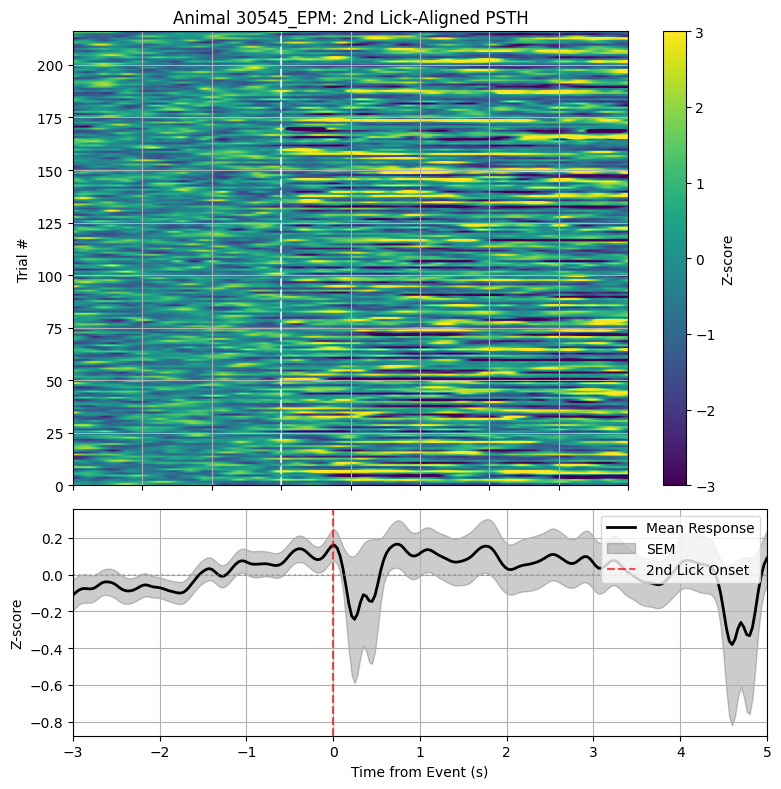


Processing Complete.
PSTH data saved in 'psth_results' for 1 animals.


In [302]:
# ---- NEW: Dictionary to store results for later usage ----
psth_results = {}

for animal_id, metrics in per_animal.items():
    # 1. Get raw data from original results
    if animal_id not in results:
        continue

    raw_data = results[animal_id]
    t = raw_data["t"]
    dff = raw_data["dff"]

    # 2. Extract Events (2nd lick of burst)
    events = metrics["lick_onset"]
    events = events[~np.isnan(events)] # Remove NaNs

    print(f"Animal {animal_id}: Found {len(events)} valid events (2nd lick of burst).")

    if len(events) < 5:
        print(f"  -> Skipping (Not enough trials)")
        continue

    # 3. Compute PSTH
    tvec, mat = compute_psth_matrix(
        t, dff, events,
        window=(-3, 5),          # 3s before to 5s after
        baseline_win=(-3, 0),    # Baseline: -3s to 0s
        smooth_sigma_s=0
    )

    # Remove rows that stayed NaN (boundary issues)
    mat = mat[~np.isnan(mat).all(axis=1)]

    if len(mat) == 0:
        continue

    # ---- SAVE TO DICTIONARY ----
    psth_results[animal_id] = {
        "time_vector": tvec,
        "psth_matrix": mat,
        "mean_trace": np.nanmean(mat, axis=0),
        "sem_trace": np.nanstd(mat, axis=0) / np.sqrt(mat.shape[0]),
        "n_trials": mat.shape[0]
    }

    # 4. Plot (Optional - can be commented out if you just want to save)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True,
                                   gridspec_kw={'height_ratios': [2, 1]})

    # A. Heatmap
    im = ax1.imshow(mat, aspect='auto', origin='lower',
                    extent=[tvec[0], tvec[-1], 0, mat.shape[0]],
                    cmap='viridis', vmin=-3, vmax=3)

    ax1.set_ylabel("Trial #")
    ax1.set_title(f"Animal {animal_id}: 2nd Lick-Aligned PSTH")
    plt.colorbar(im, ax=ax1, label="Z-score")
    ax1.axvline(0, color='w', linestyle='--', alpha=0.7)

    # B. Average Response
    mean_trace = psth_results[animal_id]["mean_trace"]
    sem_trace = psth_results[animal_id]["sem_trace"]

    ax2.plot(tvec, mean_trace, color='k', lw=2, label="Mean Response")
    ax2.fill_between(tvec, mean_trace - sem_trace, mean_trace + sem_trace,
                     color='k', alpha=0.2, label="SEM")

    ax2.axvline(0, color='r', linestyle='--', alpha=0.7, label="2nd Lick Onset")
    ax2.axhline(0, color='gray', linestyle=':', alpha=0.5)
    ax2.set_xlabel("Time from Event (s)")
    ax2.set_ylabel("Z-score")
    ax2.set_xlim(tvec[0], tvec[-1])
    ax2.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

print("\nProcessing Complete.")
print(f"PSTH data saved in 'psth_results' for {len(psth_results)} animals.")
# Usage example: psth_results['Animal_01']['psth_matrix']


Analyzing correlation between Lick Count and PSTH AUC (0s to 4s)...


C:\Users\andrianj\AppData\Local\Temp\ipykernel_1356456\3982890815.py:58: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_values = np.trapz(mat[:, idx_start:idx_end], dx=1/common_fs, axis=1)


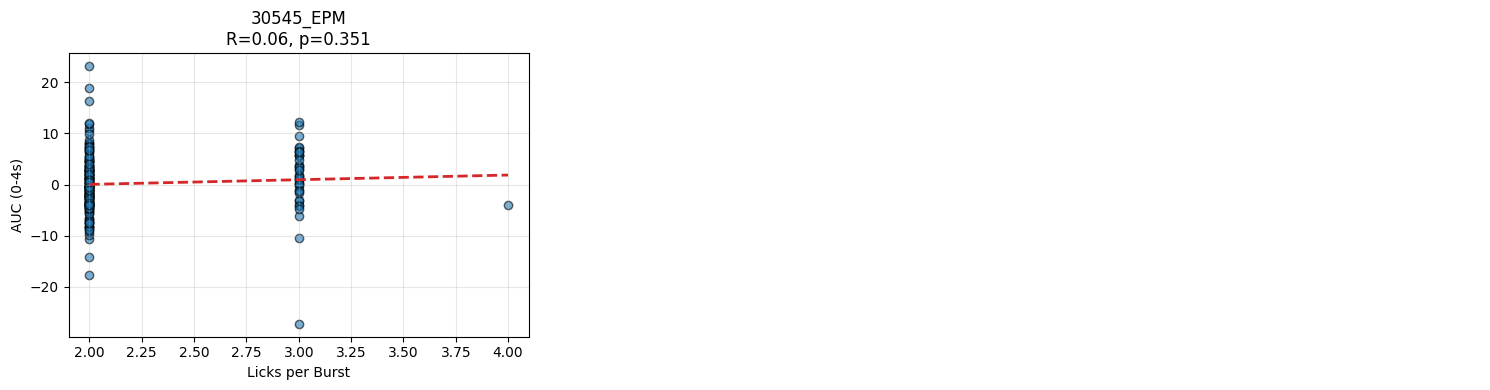

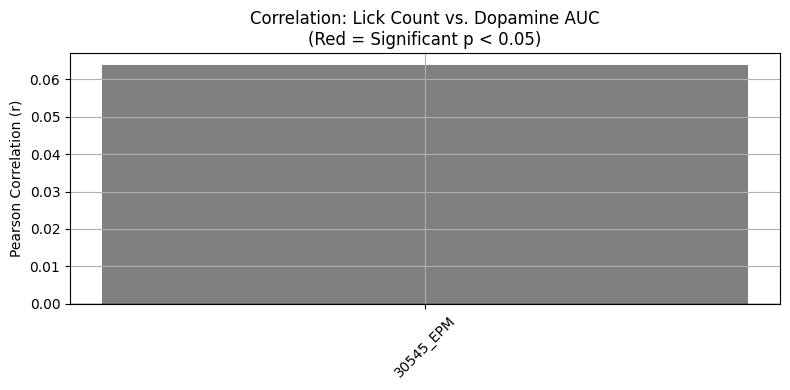

In [303]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr


# Settings
AUC_WINDOW = (0, 4)  # Window for AUC calculation (seconds)
common_fs = 1.0 / np.nanmedian(np.diff(psth_results[list(psth_results.keys())[0]]["time_vector"]))

print(f"Analyzing correlation between Lick Count and PSTH AUC ({AUC_WINDOW[0]}s to {AUC_WINDOW[1]}s)...")

# Store correlation results for summary
correlation_summary = {}

# Setup Plotting Grid (dynamic based on n_animals)
n_animals = len(psth_results)
n_cols = 3
n_rows = int(np.ceil(n_animals / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()

for i, animal_id in enumerate(sorted(psth_results.keys())):
    ax = axes[i]

    # 1. Retrieve Data
    psth_data = psth_results[animal_id]
    mat = psth_data["psth_matrix"]
    tvec = psth_data["time_vector"]

    # Retrieve trial-by-trial lick counts (burst sizes) from the metrics dict
    # Note: We must ensure alignment. The PSTH matrix rows correspond to the valid events in 'lick_onset'.
    # In the previous script, we filtered 'lick_onset' for NaNs. We must apply the same filter to 'burst_sizes'.
    raw_burst_sizes = per_animal[animal_id]["burst_sizes"]
    raw_lick_onsets = per_animal[animal_id]["lick_onset"]

    # Filter: Keep only trials that were valid for PSTH (i.e., had a valid 2nd lick)
    valid_mask = ~np.isnan(raw_lick_onsets)
    trial_lick_counts = raw_burst_sizes[valid_mask]

    # Double Check Alignment: Matrix rows vs Lick Count length
    # If PSTH matrix dropped rows due to boundary issues (edges of recording), we must truncate the lick counts too.
    # The previous script did: mat = mat[~np.isnan(mat).all(axis=1)]
    # We need to assume the 'mat' in psth_results corresponds to the *start* of the valid list.
    # If rows were dropped from the *end* or *middle* blindly, alignment is lost.
    # Ideally, we would have stored the 'valid_indices' in psth_results.
    # FORCE ALIGNMENT: Truncate to the shorter length (assuming chronological drop from ends if any)
    n_trials = min(len(trial_lick_counts), mat.shape[0])
    trial_lick_counts = trial_lick_counts[:n_trials]
    mat = mat[:n_trials, :]

    # 2. Calculate AUC for each trial
    # Find indices for the AUC window
    idx_start = np.searchsorted(tvec, AUC_WINDOW[0])
    idx_end = np.searchsorted(tvec, AUC_WINDOW[1])

    # Extract window and compute AUC (Trapezoidal rule)
    # axis=1 integrates along time
    auc_values = np.trapz(mat[:, idx_start:idx_end], dx=1/common_fs, axis=1)

    # 3. Correlation
    r_val, p_val = pearsonr(trial_lick_counts, auc_values)
    correlation_summary[animal_id] = (r_val, p_val)

    # 4. Plot
    # Scatter points
    ax.scatter(trial_lick_counts, auc_values, alpha=0.6, color='tab:blue', edgecolor='k')

    # Linear Regression Line
    m, b = np.polyfit(trial_lick_counts, auc_values, 1)
    x_fit = np.array([trial_lick_counts.min(), trial_lick_counts.max()])
    ax.plot(x_fit, m*x_fit + b, color='tab:red', linestyle='--', lw=2, label=f"Fit")

    # Styling
    ax.set_title(f"{animal_id}\nR={r_val:.2f}, p={p_val:.3f}")
    ax.set_xlabel("Licks per Burst")
    ax.set_ylabel(f"AUC ({AUC_WINDOW[0]}-{AUC_WINDOW[1]}s)")
    ax.grid(True, alpha=0.3)

# Hide empty subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

# --- Summary Plot of Correlations ---
plt.figure(figsize=(8, 4))
r_values = [v[0] for v in correlation_summary.values()]
ids = list(correlation_summary.keys())
colors = ['tab:red' if v[1] < 0.05 else 'gray' for v in correlation_summary.values()]

plt.bar(ids, r_values, color=colors)
plt.axhline(0, color='k', linewidth=1)
plt.ylabel("Pearson Correlation (r)")
plt.title("Correlation: Lick Count vs. Dopamine AUC\n(Red = Significant p < 0.05)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Aggregating data for Global Correlation (-5s to 5s)...
Total Trials Analyzed: 216


C:\Users\andrianj\AppData\Local\Temp\ipykernel_1356456\2968546013.py:61: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_values = np.trapz(mat_aligned[:, idx_start:idx_end], dx=1/fs, axis=1)


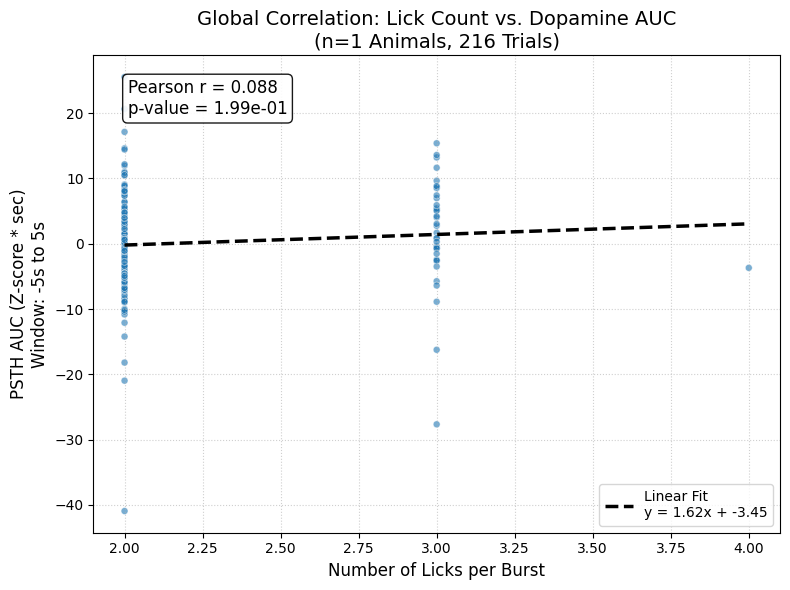

In [304]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, linregress

# =============================================================================
# Global Correlation Analysis: Pooled Data (All Animals)
# =============================================================================

# Settings
AUC_WINDOW = (-5, 5)  # Window for AUC calculation (seconds)

# Containers for pooled data
all_lick_counts = []
all_auc_values = []
animal_colors = [] # Optional: to color-code points by animal

# Setup colormap for distinguishing animals in the scatter
cmap = plt.get_cmap('tab10')
animal_ids = sorted(psth_results.keys())

print(f"Aggregating data for Global Correlation ({AUC_WINDOW[0]}s to {AUC_WINDOW[1]}s)...")

for i, animal_id in enumerate(animal_ids):
    # 1. Retrieve Data
    psth_data = psth_results[animal_id]
    mat = psth_data["psth_matrix"]
    tvec = psth_data["time_vector"]

    # Estimate sampling rate from time vector
    fs = 1.0 / np.nanmedian(np.diff(tvec))

    # 2. Retrieve & Filter Behavioral Data
    # Get raw arrays
    raw_burst_sizes = per_animal[animal_id]["burst_sizes"]
    raw_lick_onsets = per_animal[animal_id]["lick_onset"]

    # Apply the same filter used to generate the PSTH events:
    # Keep only bursts that had a valid "2nd lick" timestamp (i.e., not NaN)
    valid_behavior_mask = ~np.isnan(raw_lick_onsets)
    trial_lick_counts = raw_burst_sizes[valid_behavior_mask]

    # 3. Align Behavioral Data with PSTH Matrix
    # The PSTH matrix might be shorter if trials at the very end of the recording
    # were dropped due to window boundaries.
    n_psth_trials = mat.shape[0]
    n_behavior_trials = len(trial_lick_counts)

    # We assume chronological order, so we truncate the longer array to match the shorter one.
    n_valid = min(n_psth_trials, n_behavior_trials)

    # Truncate
    trial_lick_counts = trial_lick_counts[:n_valid]
    mat_aligned = mat[:n_valid, :]

    # 4. Calculate AUC for valid trials
    # Find indices for the integration window
    idx_start = np.searchsorted(tvec, AUC_WINDOW[0])
    idx_end = np.searchsorted(tvec, AUC_WINDOW[1])

    # Compute AUC using Trapezoidal rule along axis 1 (time)
    auc_values = np.trapz(mat_aligned[:, idx_start:idx_end], dx=1/fs, axis=1)

    # 5. Append to Global Lists
    all_lick_counts.extend(trial_lick_counts)
    all_auc_values.extend(auc_values)

    # Store color index for this batch of points
    animal_colors.extend([i] * n_valid)

# Convert to numpy arrays for analysis
all_lick_counts = np.array(all_lick_counts)
all_auc_values = np.array(all_auc_values)
animal_colors = np.array(animal_colors)

print(f"Total Trials Analyzed: {len(all_lick_counts)}")

# =============================================================================
# Statistical Analysis & Plotting
# =============================================================================

if len(all_lick_counts) > 5:
    # 1. Pearson Correlation
    r_val, p_val = pearsonr(all_lick_counts, all_auc_values)

    # 2. Linear Regression (for the fit line)
    slope, intercept, _, _, _ = linregress(all_lick_counts, all_auc_values)

    # 3. Plotting
    plt.figure(figsize=(8, 6))

    # Scatter Plot (Color-coded by animal)
    scatter = plt.scatter(all_lick_counts, all_auc_values,
                          c=animal_colors, cmap='tab10',
                          alpha=0.6, s=25, edgecolor='w', linewidth=0.5)

    # Regression Line
    x_range = np.linspace(all_lick_counts.min(), all_lick_counts.max(), 100)
    y_fit = slope * x_range + intercept

    plt.plot(x_range, y_fit, color='black', linestyle='--', linewidth=2.5,
             label=f"Linear Fit\ny = {slope:.2f}x + {intercept:.2f}")

    # Aesthetics
    plt.title(f"Global Correlation: Lick Count vs. Dopamine AUC\n(n={len(animal_ids)} Animals, {len(all_lick_counts)} Trials)", fontsize=14)
    plt.xlabel("Number of Licks per Burst", fontsize=12)
    plt.ylabel(f"PSTH AUC (Z-score * sec)\nWindow: {AUC_WINDOW[0]}s to {AUC_WINDOW[1]}s", fontsize=12)

    # Legend for Statistics
    stats_text = f"Pearson r = {r_val:.3f}\np-value = {p_val:.2e}"
    plt.text(0.05, 0.95, stats_text, transform=plt.gca().transAxes,
             fontsize=12, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))

    plt.legend(loc='lower right')
    plt.grid(True, linestyle=':', alpha=0.6)

    # Optional: Create a custom legend for animals
    # handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(i), label=aid) for i, aid in enumerate(animal_ids)]
    # plt.legend(handles=handles, title="Animal ID", loc='upper left', bbox_to_anchor=(1, 1))

    plt.tight_layout()
    plt.show()

else:
    print("Insufficient data for correlation analysis.")


Computing per-animal averages for Correlation (-1s to 4s)...
Not enough points for regression.


C:\Users\andrianj\AppData\Local\Temp\ipykernel_1356456\419417745.py:40: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  animal_auc = np.trapz(mean_trace[idx_start:idx_end], dx=1/fs)
C:\Users\andrianj\AppData\Local\Temp\ipykernel_1356456\419417745.py:104: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Animal ID")


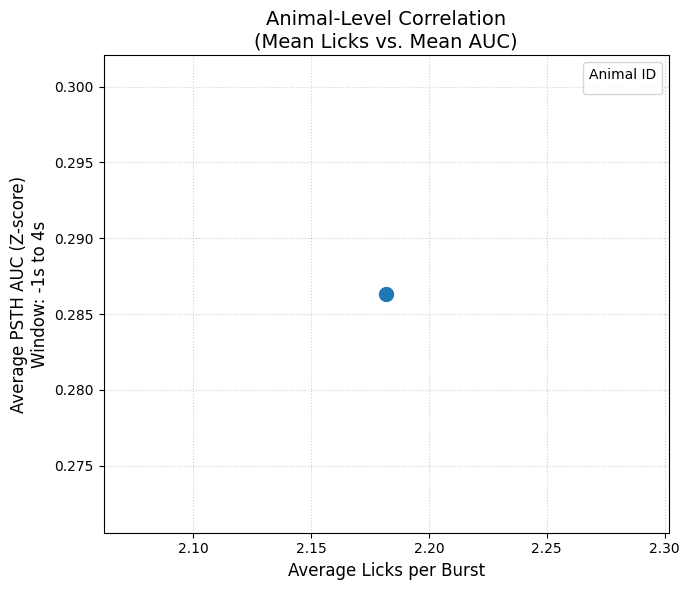


--- Summary Data ---
30545_EPM: 2.18 licks/burst | 0.29 AUC


In [305]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, linregress

# =============================================================================
# Animal-Level Correlation: Mean Licks vs. Mean AUC
# =============================================================================

# Settings
AUC_WINDOW = (-1, 4)  # Window for AUC calculation (seconds)

# Containers for animal-level means
mean_licks_per_animal = []
mean_auc_per_animal = []
animal_ids_list = []

print(f"Computing per-animal averages for Correlation ({AUC_WINDOW[0]}s to {AUC_WINDOW[1]}s)...")

for animal_id in sorted(psth_results.keys()):
    # 1. Retrieve Data
    psth_data = psth_results[animal_id]
    mat = psth_data["psth_matrix"]
    tvec = psth_data["time_vector"]

    # 2. Compute Mean AUC for this animal
    # Method: Calculate AUC for the *average trace* (more robust to noise)
    # Alternatively, you could calc AUC per trial then mean, but for Z-scores, linear operations are commutative.

    # Calculate Mean Trace first
    mean_trace = np.nanmean(mat, axis=0)

    # Estimate sampling rate
    fs = 1.0 / np.nanmedian(np.diff(tvec))

    # Find indices for integration
    idx_start = np.searchsorted(tvec, AUC_WINDOW[0])
    idx_end = np.searchsorted(tvec, AUC_WINDOW[1])

    # Compute AUC of the mean trace
    animal_auc = np.trapz(mean_trace[idx_start:idx_end], dx=1/fs)

    # 3. Compute Mean Licks for this animal
    # Retrieve raw burst sizes
    raw_burst_sizes = per_animal[animal_id]["burst_sizes"]

    # Filter for valid bursts only (same filter as PSTH events)
    raw_lick_onsets = per_animal[animal_id]["lick_onset"]
    valid_mask = ~np.isnan(raw_lick_onsets)
    valid_burst_sizes = raw_burst_sizes[valid_mask]

    # Calculate mean lick count
    if len(valid_burst_sizes) > 0:
        animal_mean_licks = np.mean(valid_burst_sizes)
    else:
        print(f"Warning: No valid bursts for {animal_id}")
        continue

    # 4. Store Data
    mean_licks_per_animal.append(animal_mean_licks)
    mean_auc_per_animal.append(animal_auc)
    animal_ids_list.append(animal_id)

# Convert to numpy arrays
x_vals = np.array(mean_licks_per_animal)
y_vals = np.array(mean_auc_per_animal)

# =============================================================================
# Plotting & Statistics
# =============================================================================

plt.figure(figsize=(7, 6))

if len(x_vals) > 1:
    # 1. Linear Regression
    slope, intercept, r_val, p_val, std_err = linregress(x_vals, y_vals)

    # 2. Plot Points
    # Use a distinct color/marker for each animal
    for i, aid in enumerate(animal_ids_list):
        plt.scatter(x_vals[i], y_vals[i], s=150, zorder=3, label=aid, edgecolor='k')
        # Annotate ID next to dot
        plt.text(x_vals[i], y_vals[i], f"  {aid}", verticalalignment='center', fontsize=9)

    # 3. Plot Fit Line
    x_range = np.array([x_vals.min() * 0.9, x_vals.max() * 1.1])
    plt.plot(x_range, slope * x_range + intercept, 'k--', alpha=0.5, zorder=2,
             label=f"Fit (r={r_val:.2f})")

    # 4. Stats Text
    stats_msg = f"Pearson r = {r_val:.3f}\np = {p_val:.3f}"
    plt.text(0.05, 0.95, stats_msg, transform=plt.gca().transAxes,
             fontsize=12, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))

else:
    plt.scatter(x_vals, y_vals, s=100)
    print("Not enough points for regression.")

# Aesthetics
plt.title("Animal-Level Correlation\n(Mean Licks vs. Mean AUC)", fontsize=14)
plt.xlabel("Average Licks per Burst", fontsize=12)
plt.ylabel(f"Average PSTH AUC (Z-score)\nWindow: {AUC_WINDOW[0]}s to {AUC_WINDOW[1]}s", fontsize=12)
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend(title="Animal ID")
plt.tight_layout()
plt.show()

# Print Data for verification
print("\n--- Summary Data ---")
for aid, licks, auc in zip(animal_ids_list, x_vals, y_vals):
    print(f"{aid}: {licks:.2f} licks/burst | {auc:.2f} AUC")


Aggregating pre-computed per-animal averages...
Averaging across 1 animals.


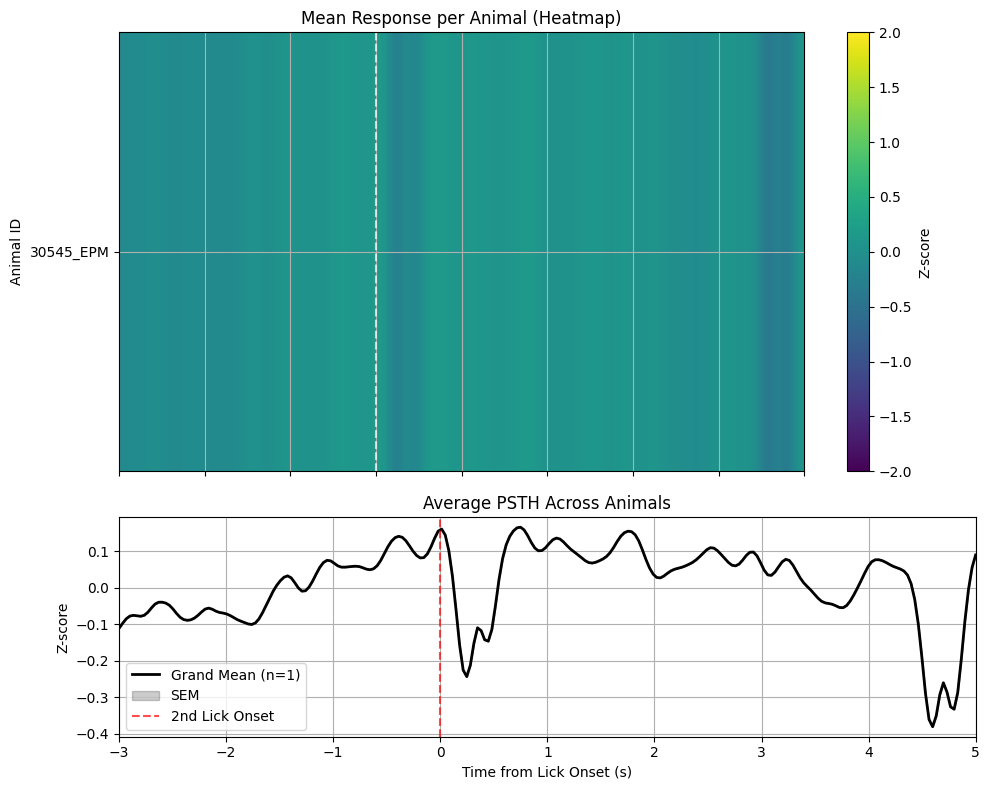

In [306]:
import numpy as np
import matplotlib.pyplot as plt

# =============================================================================
# Aggregation and Plotting using Pre-Computed 'psth_results'
# =============================================================================

# Container for animal averages
animal_mean_traces = []
animal_ids_list = []
common_tvec = None

print("Aggregating pre-computed per-animal averages...")

# Ensure psth_results exists
if 'psth_results' not in locals():
    print("Error: 'psth_results' dictionary not found. Please run the PSTH computation script first.")
else:
    for animal_id, data in psth_results.items():
        # 1. Retrieve Pre-computed Mean Trace
        mean_trace = data.get("mean_trace")
        tvec = data.get("time_vector")

        if mean_trace is None or tvec is None:
            print(f"  Warning: Missing data for {animal_id}, skipping.")
            continue

        # 2. Check for length consistency
        # Initialize common_tvec with the first valid animal
        if common_tvec is None:
            common_tvec = tvec
            expected_length = len(tvec)

        # Ensure alignment (simple length check)
        if len(mean_trace) != expected_length:
            print(f"  Warning: Length mismatch for {animal_id} ({len(mean_trace)} vs {expected_length}). Skipping.")
            continue

        # 3. Store
        animal_mean_traces.append(mean_trace)
        animal_ids_list.append(animal_id)

    # --- Plotting ---

    if len(animal_mean_traces) > 0:
        # Stack into matrix: (n_animals x n_timepoints)
        grand_matrix = np.vstack(animal_mean_traces)
        n_animals = grand_matrix.shape[0]

        # Compute Grand Average and SEM across animals
        grand_mean = np.nanmean(grand_matrix, axis=0)
        grand_sem = np.nanstd(grand_matrix, axis=0) / np.sqrt(n_animals)

        print(f"Averaging across {n_animals} animals.")

        # Create figure with 2 subplots
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

        # --- Subplot 1: Heatmap (Each line is an animal) ---
        # Extent controls the axis values: [x_min, x_max, y_min, y_max]
        # We set y to range from -0.5 to n_animals-0.5 so ticks align with integers
        im = ax1.imshow(grand_matrix, aspect='auto', origin='lower',
                        extent=[common_tvec[0], common_tvec[-1], -0.5, n_animals - 0.5],
                        cmap='viridis', vmin=-2, vmax=2) # Adjust vmin/vmax for Z-score visibility

        ax1.set_yticks(range(n_animals))
        ax1.set_yticklabels(animal_ids_list)
        ax1.set_ylabel("Animal ID")
        ax1.set_title("Mean Response per Animal (Heatmap)")
        ax1.axvline(0, color='w', linestyle='--', alpha=0.7)
        plt.colorbar(im, ax=ax1, label="Z-score")

        # --- Subplot 2: Grand Average Trace ---
        # Plot individual animal traces (faint lines)
        for i in range(n_animals):
            ax2.plot(common_tvec, grand_matrix[i, :], color='gray', alpha=0.3, lw=1)

        # Plot Grand Mean + SEM
        ax2.plot(common_tvec, grand_mean, color='k', lw=2, label=f"Grand Mean (n={n_animals})")
        ax2.fill_between(common_tvec, grand_mean - grand_sem, grand_mean + grand_sem,
                        color='k', alpha=0.2, label="SEM")

        ax2.axvline(0, color='r', linestyle='--', alpha=0.7, label="2nd Lick Onset")
        ax2.set_xlabel("Time from Lick Onset (s)")
        ax2.set_ylabel("Z-score")
        ax2.set_title("Average PSTH Across Animals")
        ax2.set_xlim(common_tvec[0], common_tvec[-1])
        ax2.legend()

        plt.tight_layout()
        plt.show()
    else:
        print("No valid data to average.")
